# **Telco Customer Churn Prediction**

### **📌 Business Case**
Telecommunications companies lose millions annually due to customer churn. Anticipating this behavior allows the company to act preventively, offering personalized benefits or solutions to keep the customer in the base.

### **🎯 Objective**
Predict whether a customer is likely to cancel service based on their contractual, demographic and usage data.

In [2]:
import pandas as pd 
from config.paths_config import *
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE
import mlflow
import mlflow.sklearn
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier

In [3]:
data= pd.read_csv(RAW_DATA)

## **🔍 1. Data Exploration**
In this section, we will perform an initial exploration of the dataset with the goal of understanding its structure, quality, and key characteristics. This analysis is essential to identify potential consistency issues, incorrect data types, missing values, and relevant patterns that may influence predictive modeling.

### **1.1. Overview do Dataset**

In [4]:
data.shape

(7043, 21)

In [5]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# Adjusting the data type of the Total Charges column to numeric:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Ajustar a coluna de SeniorCitizen para categorica:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)

### **1.2. Check for null/missing values**

In [8]:
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
# substituindo os valores zeros com a média: 
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\557593382.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


### **1.3. Check unique values ​​per column**

In [10]:
for col in data.columns:
    print(f"{col}: {data[col].nunique()} unique values")

customerID: 7043 unique values
gender: 2 unique values
SeniorCitizen: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
tenure: 73 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
MonthlyCharges: 1585 unique values
TotalCharges: 6531 unique values
Churn: 2 unique values


Based on the count of unique values ​​per column, we can draw the following conclusions:

**1. Identification of categorical and numerical variables:**

- Most variables with up to 4 unique values ​​are categorical (e.g. `gender`, `Partner`, `InternetService`, `Churn`), which can be encoded with **LabelEncoder** or **OneHotEncoder**.

- The columns `MonthlyCharges`, `TotalCharges`, and `tenure` have many unique values ​​and are continuous numeric variables, suitable for statistical analysis and normalization.

**2. `customerID` column:**

- It has 7043 unique values ​​(equal to the total number of records), being a unique identifier. This column is not useful for modeling and can be discarded.

**3. Columns with 3 unique values:**

- Variables like `MultipleLines`, `OnlineSecurity`, `TechSupport`, etc., are likely to contain categories like "Yes", "No", and "No internet service" — these categories require careful preprocessing, as "No internet service" may or may not be grouped with "No" depending on the context of the model.

**4. Target variable (Churn):**

- It contains only 2 categories (Yes, No), which confirms that we are dealing with a binary classification problem.

## **📊 2. Univariate Analysis**

### **2.1. Variáveis Numéricas**

In [11]:
def analyze_numeric_variables(df, coluna_numerica):
    plt.figure(figsize=(14, 5))

    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(df[coluna_numerica], kde=True, bins=30, color='skyblue')
    plt.title(f'Histograma of {coluna_numerica}')
    plt.xlabel(coluna_numerica)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[coluna_numerica], color='lightgreen')
    plt.title(f'Boxplot de {coluna_numerica}')
    plt.xlabel(coluna_numerica)

    plt.tight_layout()
    plt.show()

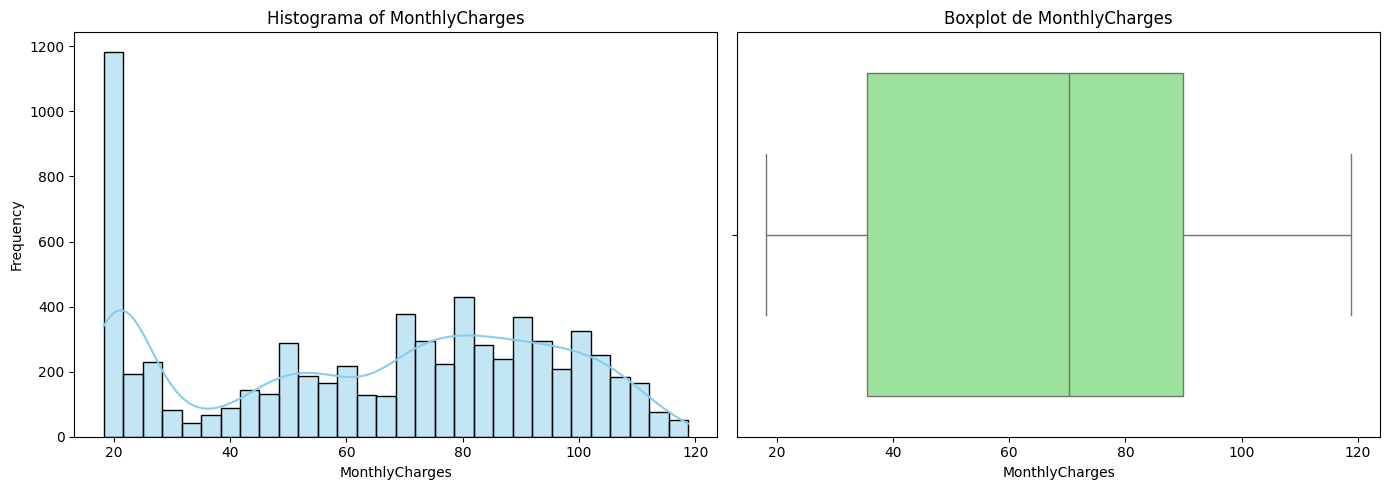

In [12]:
analyze_numeric_variables(data, coluna_numerica='MonthlyCharges')

**Histograma de MonthlyCharges:**

- Distribuição assimétrica à direita (ou seja, distribuição positiva): A maior concentração de clientes paga valores mais baixos, em torno de 20 a 30 unidades monetárias, com uma cauda se estendendo para valores mais altos.

- Picos visíveis indicam que há grupos distintos de clientes com planos mensais em faixas de preço específicas, o que pode refletir diferentes pacotes de serviços oferecidos.

**Boxplot de MonthlyCharges:**

- A mediana (linha no meio da caixa) está entre 70 e 75, indicando que metade dos clientes paga até esse valor.

- A caixa (que representa o intervalo interquartil, ou seja, do 1º ao 3º quartil) é bem larga, mostrando alta dispersão nos valores cobrados, indicando a possibilidade de haver uma ampla oferta de serviços prestados.

- Há poucos ou nenhum outlier visível, o que indica que os valores extremos não são muito fora do padrão.

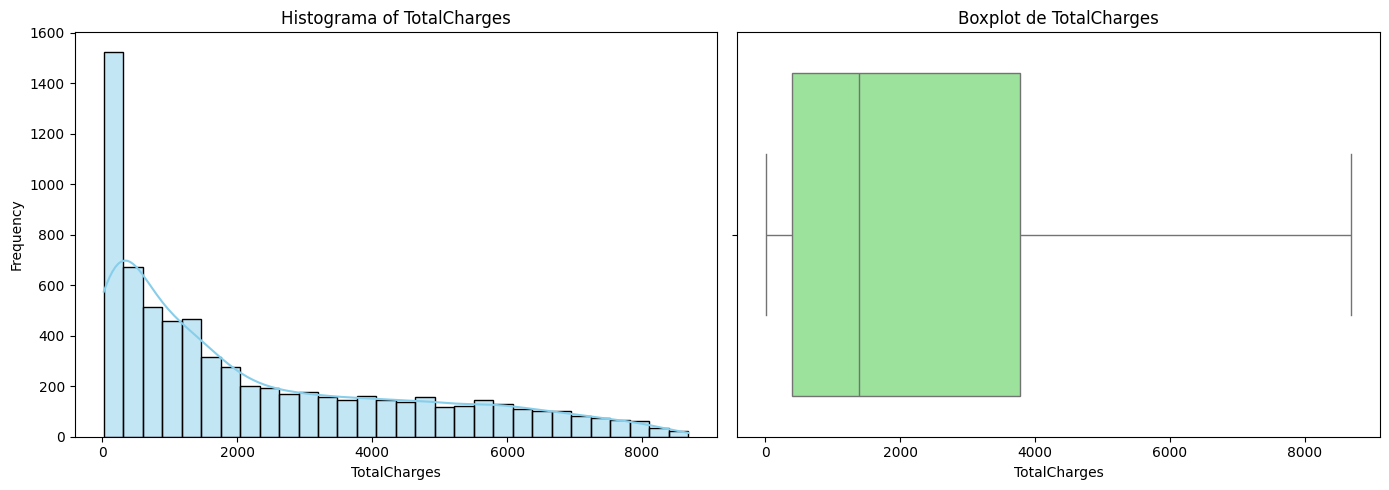

In [13]:
analyze_numeric_variables(data, coluna_numerica='TotalCharges')

**Histograma de TotalCharges**:
- Distribuição altamente assimétrica à direita (positivamente enviesada):

- A maioria dos clientes tem um `TotalCharges` (valor total pago até hoje) baixo, abaixo de 2.000 unidades monetárias. O que pode indicar a maior venda se serviços de catogorias mais baratas 

- A cauda longa mostra que poucos clientes já pagaram valores acima de 5.000.

**Boxplot TotalCharges**:
- A maior parte dos dados está concentrada no intervalo interquartil (IQR) até cerca de 4.000.
- Existem outliers com valores mais altos — clientes que estão há muito tempo ou com planos caros.

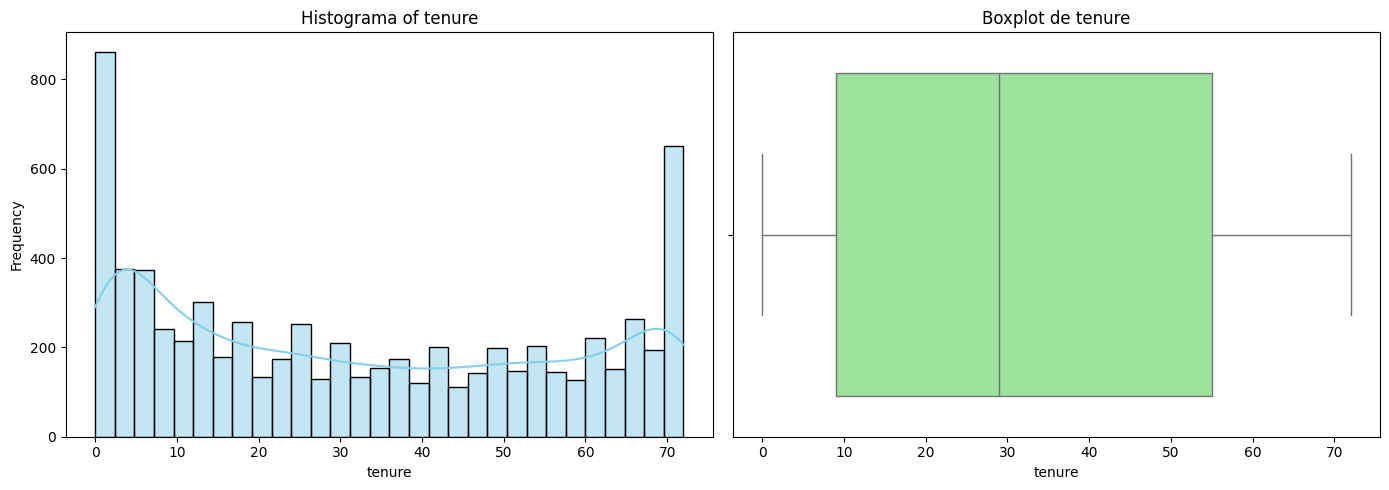

In [14]:
analyze_numeric_variables(data, coluna_numerica='tenure')

A varivel `tenure`seria um idicador que representa o **tempo de permanecia do cliente na empresa** nesse caso em meses. 

- Se **tenure = 1**, o cliente entrou no último mês.

- Se **tenure = 72**, o cliente está com a empresa há 6 anos.

**Histograma de Tenure**:

- Alta concentração de clientes com pouquíssimo tempo de casa (principalmente nos 3 primeiros meses).
- Há também um pico em 72 meses, indicando clientes muito fiéis.
- Entre esses extremos, a distribuição é bem espalhada, mas com menos frequência no meio (clientes de 20 a 50 meses são menos comuns).

**Boxplot**:
- O mediano está por volta de 30 meses.

- A distribuição é relativamente equilibrada, mas com leve assimetria à esquerda, já que há mais clientes com pouco tempo.

### **2.2. Variáveis Categóricas**

In [15]:
def analisar_frequencia(df, coluna, top_n=None, figsize=(10, 5), palette="viridis"):
    """
    Exibe a frequência dos valores únicos de uma coluna e plota um gráfico de barras com os valores no topo.

    Parâmetros:
    - df: DataFrame
    - coluna: nome da coluna para análise
    - top_n: número de categorias mais frequentes para exibir (None = todas)
    - figsize: tamanho da figura
    - palette: paleta de cores do seaborn
    """
    # Verifica se a coluna existe
    if coluna not in df.columns:
        print(f"Coluna '{coluna}' não encontrada no DataFrame.")
        return
    
    # Frequência de valores
    freq = df[coluna].value_counts().sort_values(ascending=False)

    # Exibir tabela
    print(f"\nFrequência dos valores únicos na coluna '{coluna}':\n")
    display(freq.head(top_n) if top_n else freq)

    # Dados para o gráfico
    x = freq.head(top_n).index if top_n else freq.index
    y = freq.head(top_n).values if top_n else freq.values

    # Plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y=y, palette=palette)
    plt.title(f"Frequência dos valores únicos em '{coluna}'")
    plt.xlabel(coluna)
    plt.ylabel("Frequência")
    plt.xticks(rotation=45)

    # Adiciona os valores no topo das barras
    for i, value in enumerate(y):
        ax.text(i, value + max(y)*0.01, str(value), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()



Frequência dos valores únicos na coluna 'gender':



gender
Male      3555
Female    3488
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


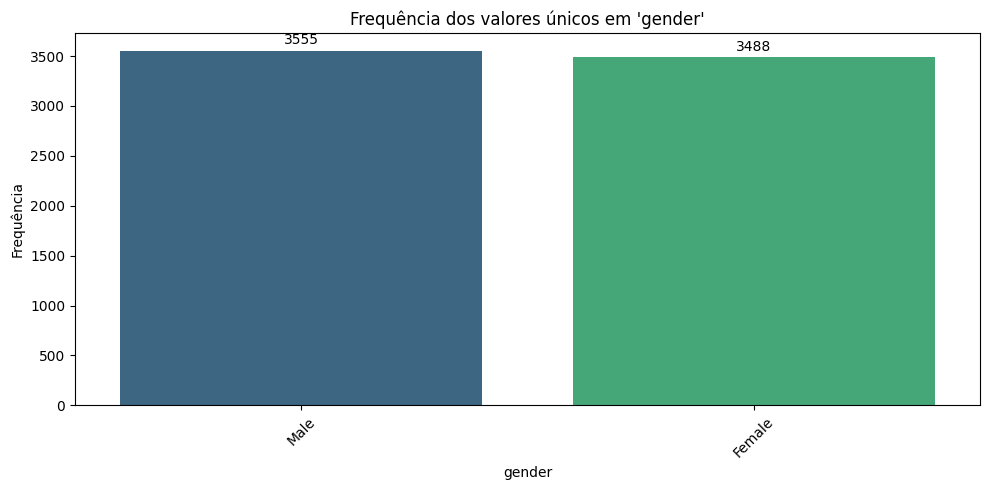

In [16]:
# Analisar frequência da coluna 'Contract'
analisar_frequencia(data, 'gender')

- A distribuição entre os gêneros é bastante equilibrada no conjunto de dados.

- Existem 3.555 clientes do sexo masculino (50,5%) e 3.488 do sexo feminino (49,5%).

- Isso indica que não há viés significativo em relação ao gênero na base, o que é importante para evitar distorções durante o treinamento do modelo.


Frequência dos valores únicos na coluna 'SeniorCitizen':



SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


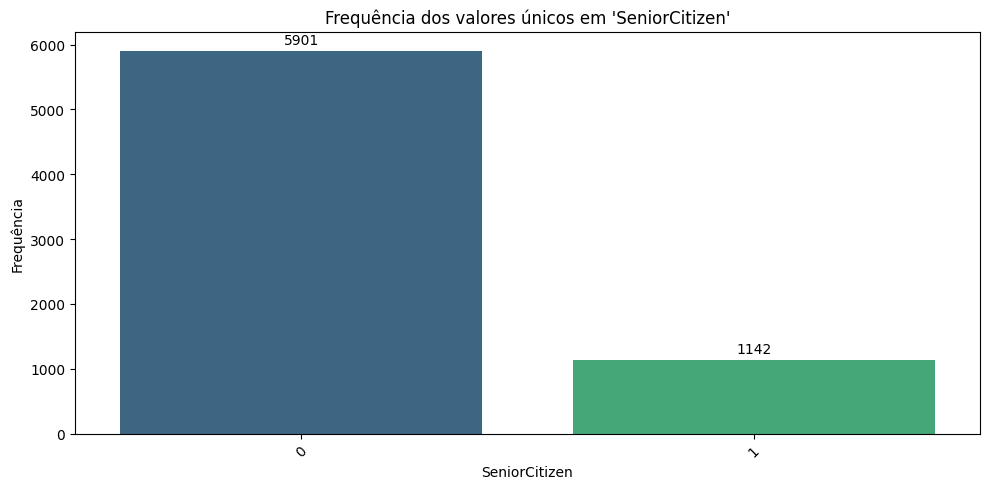

In [17]:
analisar_frequencia(data, 'SeniorCitizen')

- Há um forte desbalanceamento na distribuição desta variável.

- Aproximadamente 84% dos clientes (5.901) não são idosos (`SeniorCitizen = 0`), enquanto apenas 16% (1.142) são considerados idosos (`SeniorCitizen = 1`).

- Esse desequilíbrio pode impactar a capacidade do modelo de aprender padrões relevantes para o grupo menor (idosos), especialmente se a variável tiver relação com o churn.

- Portanto, é importante verificar se clientes idosos têm taxas de cancelamento diferentes, e considerar técnicas de balanceamento (como oversampling ou stratified sampling) se necessário.


Frequência dos valores únicos na coluna 'Partner':



Partner
No     3641
Yes    3402
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


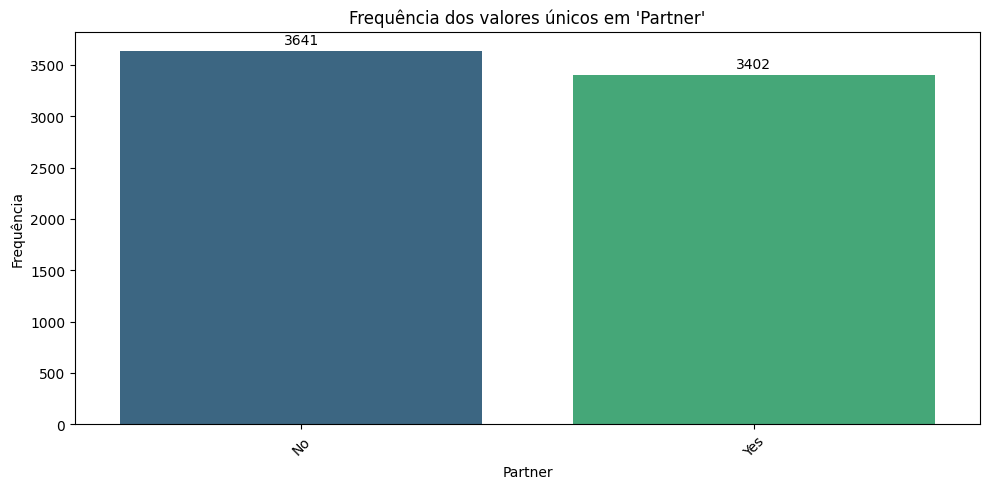

In [18]:
analisar_frequencia(data, 'Partner')

- A distribuição entre clientes com e sem parceiro é relativamente equilibrada, mas com uma leve predominância de clientes sem parceiro.

- 51,7% dos clientes (3.641) não possuem parceiro (`Partner = No`), enquanto 48,3% (3.402) possuem (`Partner = Yes`).

- Esse leve desbalanceamento não deve impactar negativamente o modelo, mas é interessante analisar se a presença de um parceiro influencia a retenção ou cancelamento do serviço (Churn).


Frequência dos valores únicos na coluna 'Dependents':



Dependents
No     4933
Yes    2110
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


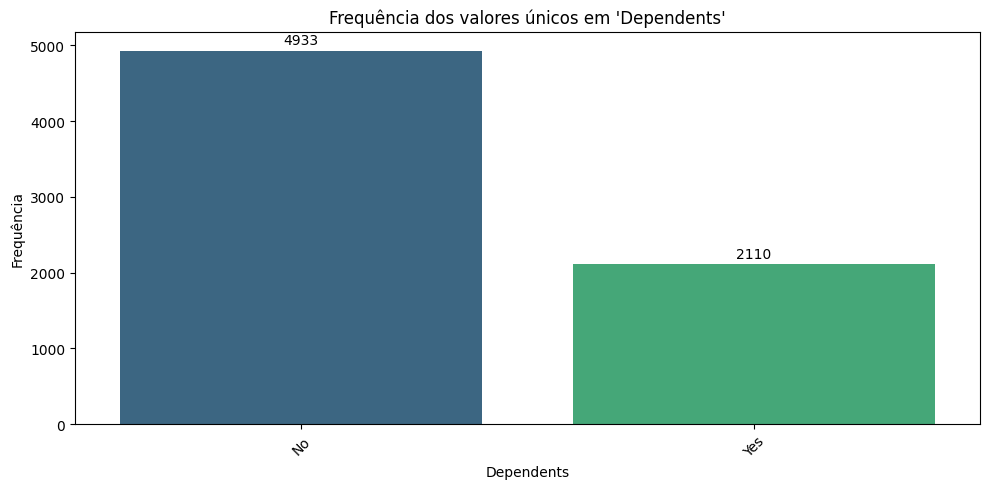

In [19]:
analisar_frequencia(data, 'Dependents')

- A distribuição revela um forte desbalanceamento:

- 70,1% dos clientes (4.933) não possuem dependentes (`Dependents = No`),

- enquanto apenas 29,9% (2.110) possuem dependentes (`Dependents = Yes`).

- Isso pode indicar que a base de clientes é composta majoritariamente por pessoas sem filhos ou dependentes financeiros — possivelmente solteiros ou casais sem filhos. É importante verificar se a presença de dependentes está associada ao comportamento de cancelamento (Churn). Clientes com dependentes podem demonstrar maior estabilidade e compromisso com serviços contratados, o que pode influenciar a taxa de cancelamento.


Frequência dos valores únicos na coluna 'PhoneService':



PhoneService
Yes    6361
No      682
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


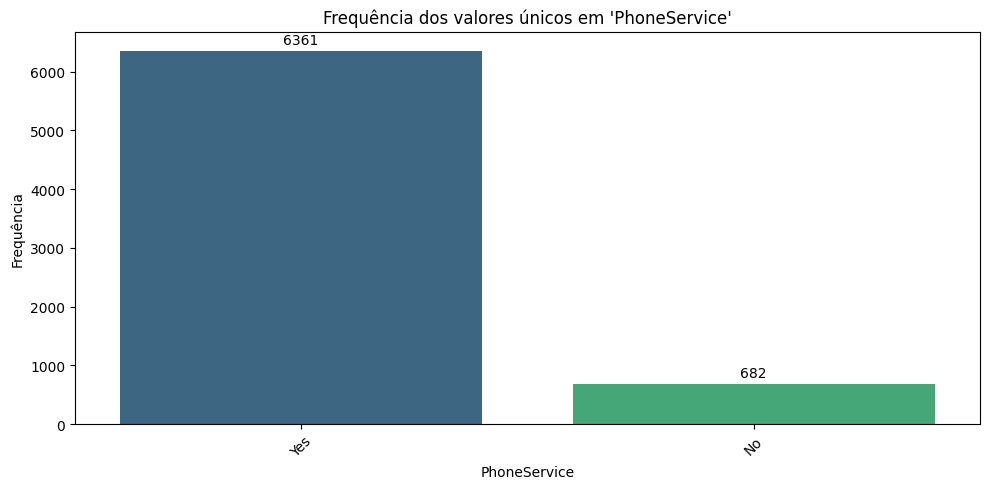

In [20]:
analisar_frequencia(data, 'PhoneService')

- A distribuição mostra um forte desbalanceamento entre os clientes que possuem serviço telefônico e os que não possuem:

- 90,3% dos clientes (6.361) têm `PhoneService = Yes`;

- Apenas 9,7% (682) não possuem esse serviço.

- Esse padrão pode indicar que o serviço telefônico é **quase um padrão nos pacotes contratados** pela base de clientes, funcionando como um serviço base ao qual outros produtos podem ser agregados (como internet, streaming ou suporte técnico).

- Do ponto de vista do churn, pode ser interessante investigar:

    - Se clientes sem `PhoneService` apresentam maior ou menor propensão ao cancelamento;

    - Se o serviço telefônico contribui para maior fidelização quando incluído em pacotes.




Frequência dos valores únicos na coluna 'MultipleLines':



MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


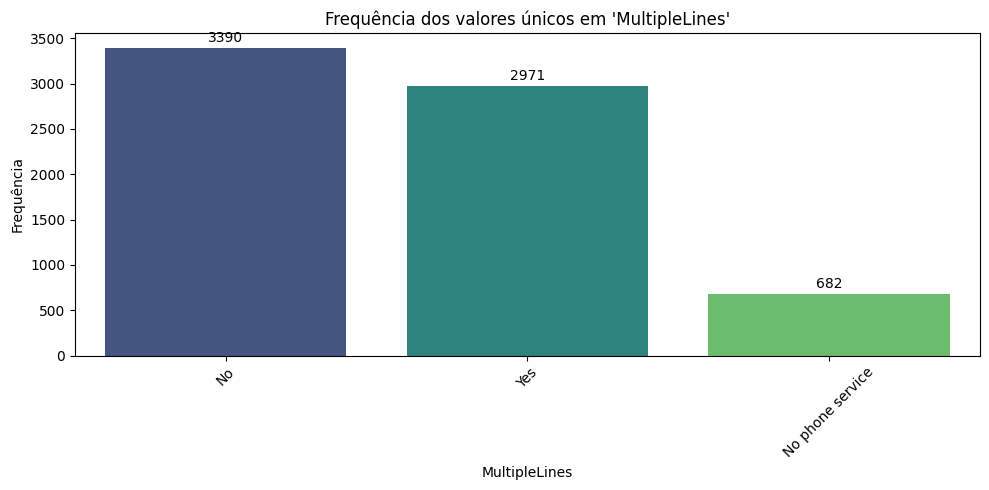

In [21]:
analisar_frequencia(data, 'MultipleLines')

- A maioria dos clientes possui uma única linha (3390) versus múltiplas linhas (2971). Além disso, tem um grupo significativo que não possui serviço telefônico (682).

- Clientes com múltiplas linhas geralmente são residências ou empresas maiores e, em geral, podem ter um valor de receita maior.

- Clientes com uma única linha podem ser mais sensíveis ao preço ou ao serviço — potencialmente mais propensos ao churn.

- O grafico acima pode indicar que a empresa tende a atender mais clientes que solicitam somente uma linha como serviço. 

-  Vale aprofundar com análise da taxa de churn por categoria para validar se a feature impacta fortemente o risco de cancelamento.


Frequência dos valores únicos na coluna 'InternetService':



InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


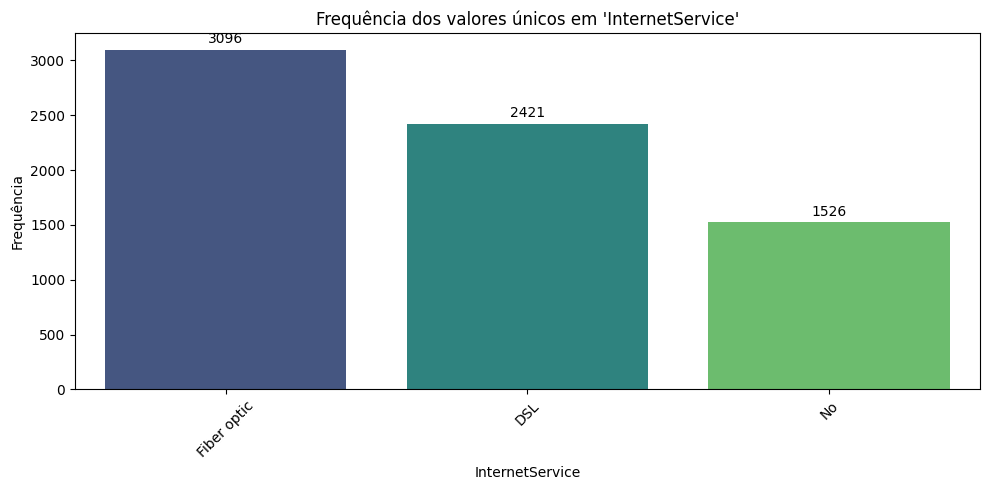

In [22]:
analisar_frequencia(data, 'InternetService')

- A maior parte dos clientes usa Fiber optic (3096), seguido por DSL (2421) e depois clientes que não possuem serviço de internet (1526).

- Nesse contexto, vale a pena analisar se clientes com fibra óptica têm taxas de churn maiores ou menores, pois embora seja o serviço mais moderno, o custo também pode ser maior junto com a concorrência.

- Avaliar se clientes com DSL estão mais propensos a cancelar por problemas técnicos ou insatisfação com velocidade.

- Para clientes sem internet, as estratégias de retenção podem focar em outros serviços.

- Para a construção do modelo: 
    - A variável `InternetService` pode ser altamente relevante, pois indica o tipo de serviço contratado, que tem impacto direto na satisfação e, consequentemente, no churn.
    - Nesse caso, vale a pena calcular a taxa de churn para cada categoria para entender o comportamento dos grupos.
    - Verificar se há interações dessa variável com outras, como preço mensal, contrato, serviços adicionais.


Frequência dos valores únicos na coluna 'OnlineSecurity':



OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


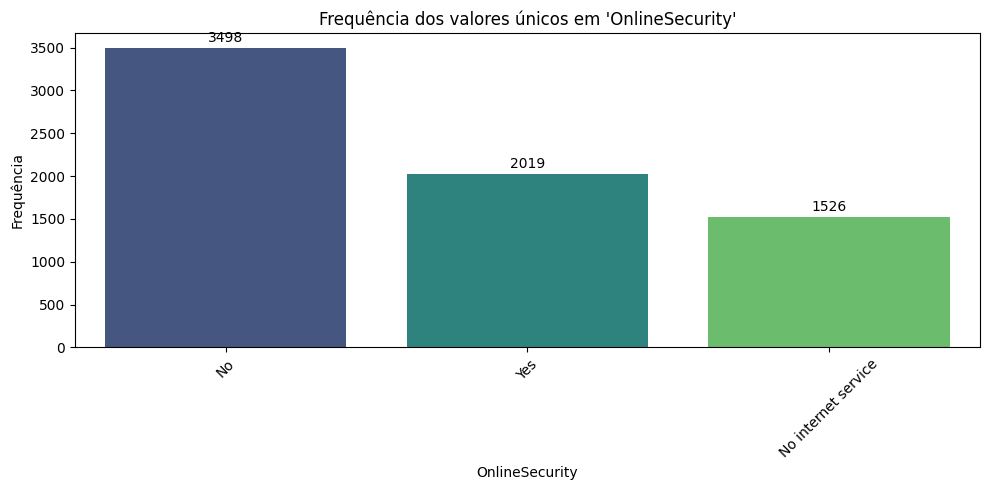

In [23]:
analisar_frequencia(data, 'OnlineSecurity')

- O número elevado de clientes que não utilizam o serviço de segurança online, mesmo entre os que possuem internet, pode indicar:

    - Falta de percepção de valor por parte do cliente sobre esse serviço.
    - Problemas na comunicação ou oferta do serviço por parte da empresa.
    - Sensibilidade a preços, especialmente se o serviço for cobrado à parte.

- Isso pode ser uma oportunidade para campanhas de upselling, focadas em segurança digital, especialmente em um cenário onde ameaças cibernéticas são cada vez mais comuns.

- Também é importante verificar se a ausência desse serviço está correlacionada com o churn, ou seja:

    - Verificar se clientes sem segurança online estão mais propensos a cancelar. Se sim, oferecer esse serviço como benefício em estratégias de retenção pode ser eficaz.


Frequência dos valores únicos na coluna 'OnlineBackup':



OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


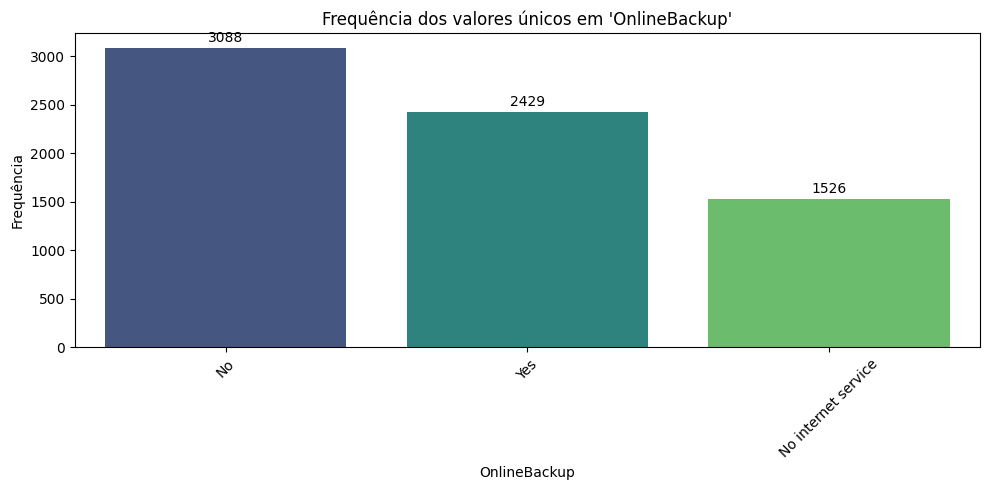

In [24]:
analisar_frequencia(data, 'OnlineBackup')

- A análise da variável `OnlineBackup` mostra que uma parcela significativa dos clientes com acesso à internet não contratou o serviço de backup online, enquanto uma parte menor utiliza o serviço regularmente. Outros 1.526 clientes não possuem internet, estando, portanto, inelegíveis ao serviço.

- Do ponto de vista estratégico, essa variável pode indicar o nível de engajamento dos clientes com os serviços digitais oferecidos pela empresa. Caso clientes que utilizam o serviço apresentem menor propensão ao churn, essa funcionalidade pode ser usada como um elemento de fidelização. Portanto, vale incluir essa variável na modelagem preditiva e investigar sua relação com o cancelamento de serviços.


Frequência dos valores únicos na coluna 'DeviceProtection':



DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


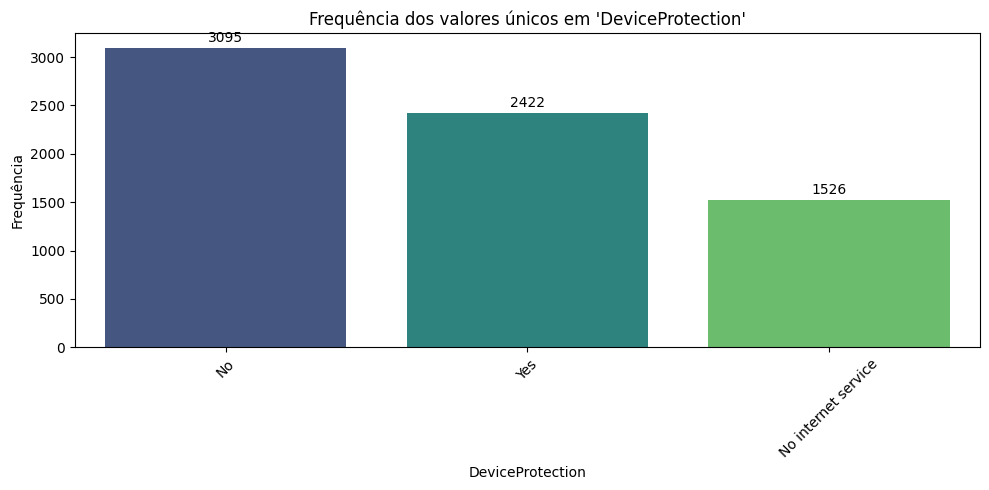

In [25]:
analisar_frequencia(data, 'DeviceProtection')

- A variável `DeviceProtection` mostra que a maioria dos clientes com internet optou por não contratar o serviço de proteção de dispositivo, enquanto uma parcela considerável faz uso desse benefício. Outros 1.526 clientes não possuem serviço de internet e, portanto, não são elegíveis ao serviço.

- Esse padrão pode indicar uma baixa percepção de valor ou baixa atratividade do serviço, o que representa uma oportunidade para ações comerciais e de fidelização. Se o uso do serviço estiver associado a menores taxas de churn, a oferta de `DeviceProtection` pode ser usada como uma estratégia preventiva de retenção. Por isso, essa variável deve ser mantida na modelagem preditiva, pois pode representar um indicativo importante de comportamento do cliente.


Frequência dos valores únicos na coluna 'TechSupport':



TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


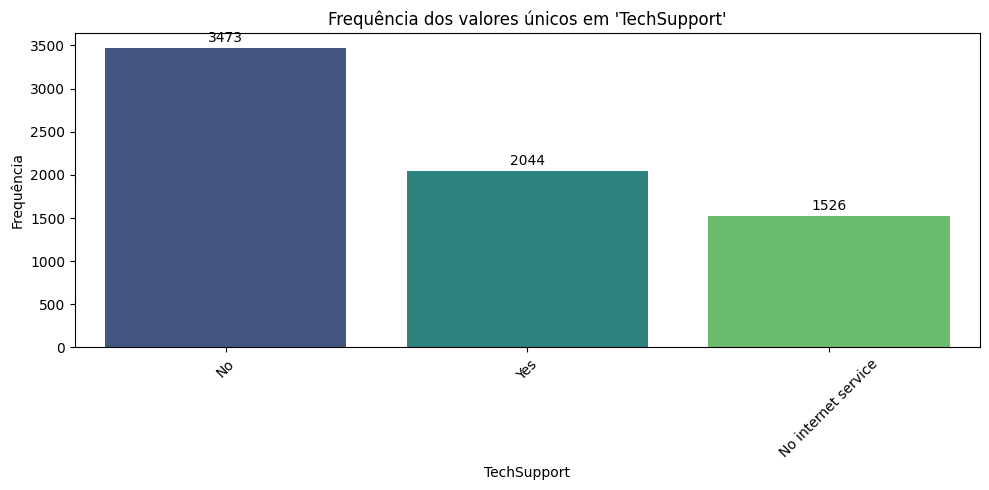

In [26]:
analisar_frequencia(data, 'TechSupport')

- A variável `TechSupport` mostra que a maior parte dos clientes com acesso à internet não contratou o serviço de suporte técnico. Já 2.044 clientes o utilizam regularmente, enquanto 1.526 clientes não possuem serviço de internet e, portanto, não são elegíveis ao suporte.

- Do ponto de vista estratégico, o serviço de suporte técnico pode ser um importante diferencial na experiência do cliente, principalmente em momentos críticos. Caso se observe uma menor taxa de churn entre os clientes que utilizam esse serviço, ele poderá ser posicionado como ferramenta de retenção ou incluído em ofertas personalizadas. Sendo assim, é recomendado que a variável seja considerada na modelagem preditiva como um possível indicador de engajamento e fidelização.


Frequência dos valores únicos na coluna 'StreamingTV':



StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


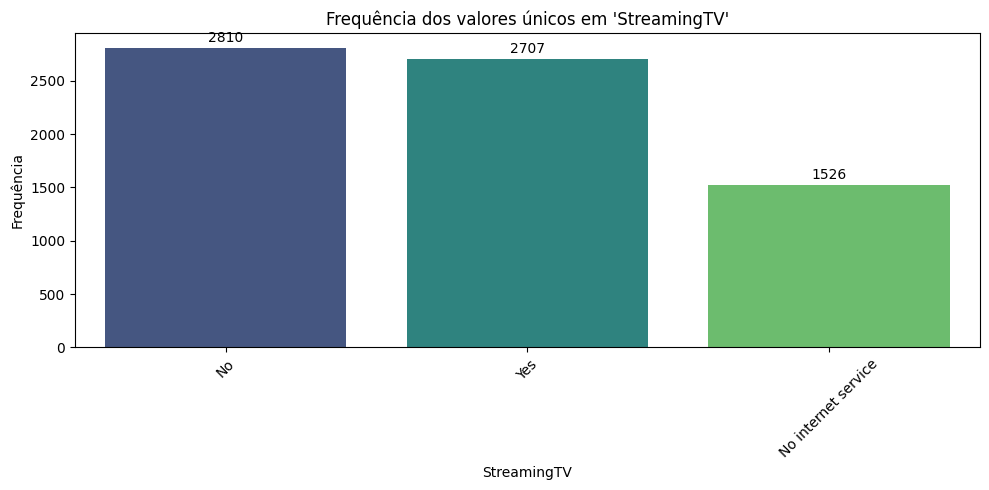

In [27]:
analisar_frequencia(data, 'StreamingTV')

- A variável `StreamingTV` apresenta uma distribuição equilibrada entre clientes que contrataram o serviço (2.707) e os que optaram por não contratar (2.810), entre aqueles com acesso à internet. Outros 1.526 clientes não possuem serviço de internet e, portanto, não têm acesso ao serviço de TV por streaming.

- Essa divisão equilibrada pode indicar que o serviço tem boa aceitação no mercado, mas ainda há margem para crescimento. Caso a contratação do serviço esteja associada a menor propensão ao churn, sua oferta pode ser posicionada como um benefício estratégico para retenção de clientes. Dessa forma, é recomendável incluir `StreamingTV` na modelagem preditiva como uma variável potencialmente relevante para identificar o nível de engajamento do cliente


Frequência dos valores únicos na coluna 'StreamingMovies':



StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


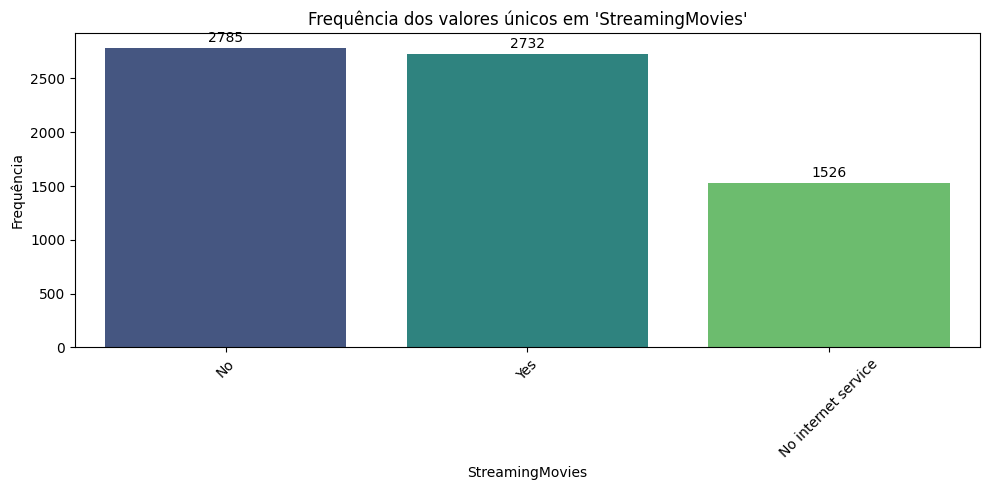

In [28]:
analisar_frequencia(data, 'StreamingMovies')

- A variável `StreamingMovies` apresenta uma divisão quase equilibrada entre os clientes com internet: 2.732 contrataram o serviço e 2.785 não contrataram. Outros 1.526 clientes não possuem acesso à internet, tornando-se inelegíveis ao serviço.

- Essa paridade sugere que o serviço de filmes tem boa aceitação entre os usuários, mas ainda há potencial de crescimento. Se for confirmado que os clientes que utilizam esse tipo de serviço têm menor propensão ao churn, ele pode ser explorado como uma ferramenta de fidelização, inclusive por meio de pacotes combinados.

- Dessa forma, `StreamingMovies` deve ser considerada uma variável relevante para a modelagem preditiva, uma vez que pode refletir o nível de engajamento e propensão à permanência do cliente.


Frequência dos valores únicos na coluna 'Contract':



Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


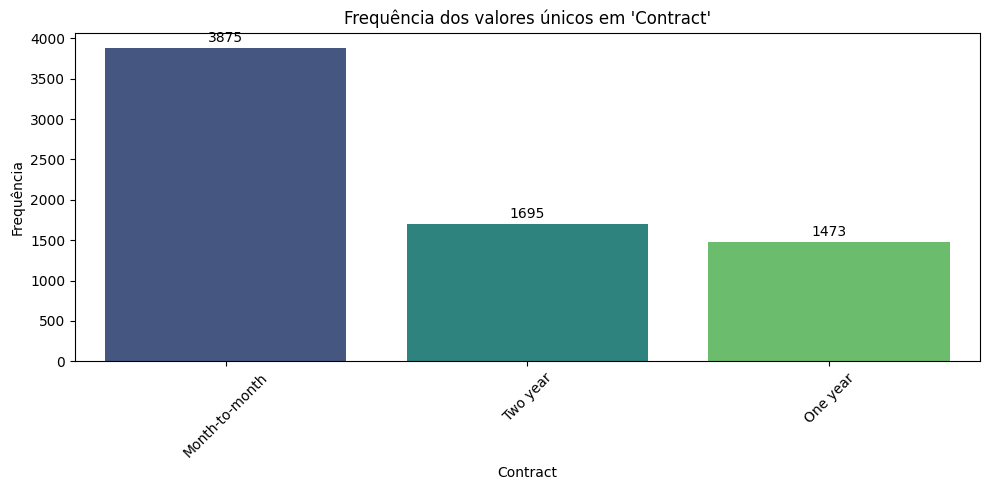

In [29]:
analisar_frequencia(data, 'Contract')

- A variável `Contract` revela que mais de 60% dos clientes estão no plano `Month-to-month`, ou seja, sem vínculo contratual de longo prazo. Isso indica uma base altamente volátil, com maior risco de cancelamento. Já os contratos `One year` e `Two year` representam uma fatia menor, porém tende a ser mais estável e comprometida.

- Dado que planos mensais geralmente apresentam taxas de churn mais altas, essa variável pode ser crítica tanto para a modelagem preditiva quanto para ações de retenção. Iniciativas que incentivem a migração para contratos mais longos podem ajudar a estabilizar a base e reduzir perdas de receita. Portanto, `Contract` deve ser considerada uma das variáveis mais relevantes para previsão de churn, e pode também ser usada como base para campanhas direcionadas de fidelização.


Frequência dos valores únicos na coluna 'PaperlessBilling':



PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


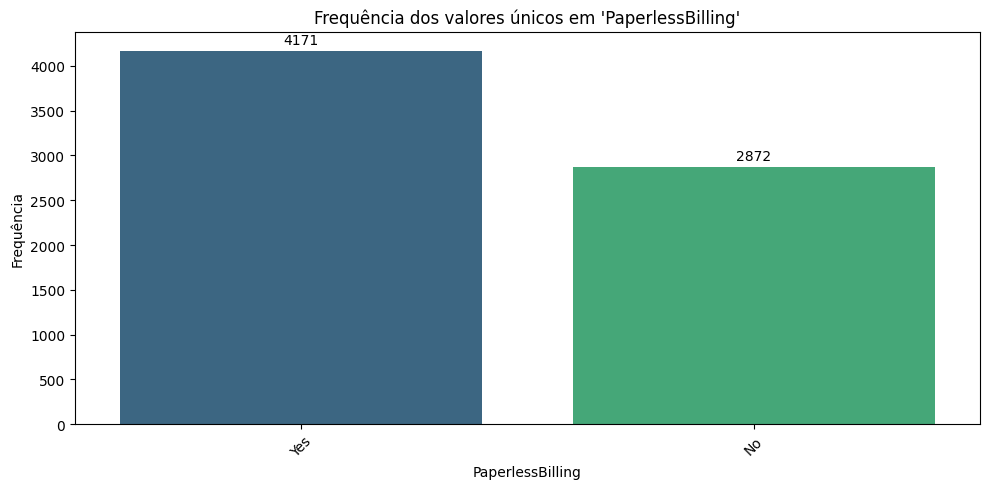

In [30]:
analisar_frequencia(data, 'PaperlessBilling')

- A maioria dos clientes (cerca de 59%) optou pelo faturamento digital (`PaperlessBilling = Yes`), o que pode indicar maior familiaridade com canais online e preferência por praticidade.

- No entanto, em muitos casos, esse perfil também está associado a maior risco de churn, especialmente quando combinado a contratos mensais (visto a facilidade para o cancelamento do serviço). Já os clientes com `PaperlessBilling = No` podem representar uma base mais conservadora, porém mais estável. Assim, essa variável deve ser considerada na modelagem preditiva, pois pode ajudar a capturar diferentes níveis de engajamento e comportamento do cliente frente aos serviços da empresa.


Frequência dos valores únicos na coluna 'PaymentMethod':



PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


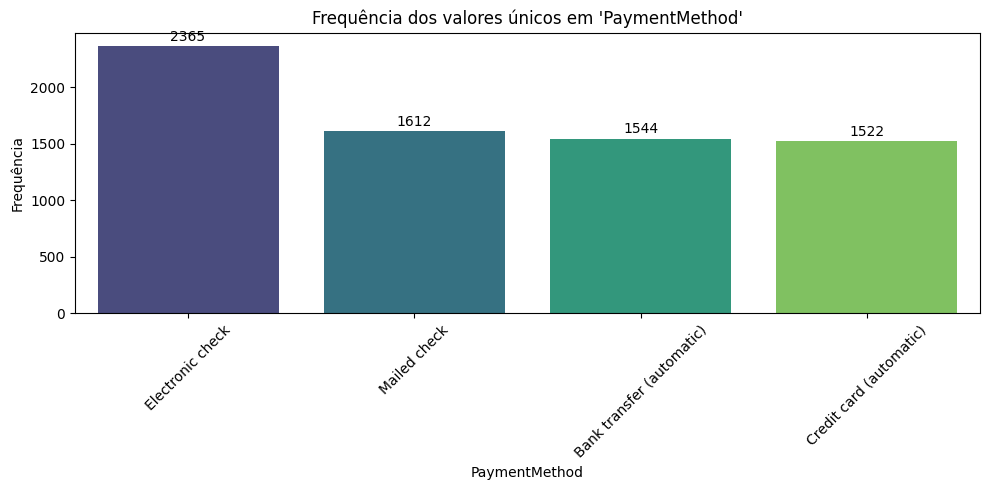

In [31]:
analisar_frequencia(data, 'PaymentMethod')

- A variável `PaymentMethod` revela diferenças importantes no perfil dos clientes. O método mais comum é o `Electronic check`, seguido por `Mailed check`, enquanto os métodos automáticos (`Bank transfer` e `Credit card`) são menos usados.

- Métodos automáticos estão frequentemente associados a **clientes mais estáveis e menos propensos ao churn**, pois envolvem menor esforço recorrente. Por outro lado, clientes que usam `Electronic check` tendem a apresentar **maior risco de cancelamento**, possivelmente por estarem mais suscetíveis a dificuldades no pagamento ou menor engajamento.

- Assim, essa variável pode ter um forte valor preditivo e pode contribuir para estratégias que incentivem migração para métodos automáticos, como forma de aumentar a retenção.


Frequência dos valores únicos na coluna 'Churn':



Churn
No     5174
Yes    1869
Name: count, dtype: int64

C:\Users\eduar\AppData\Local\Temp\ipykernel_14364\60397596.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=x, y=y, palette=palette)


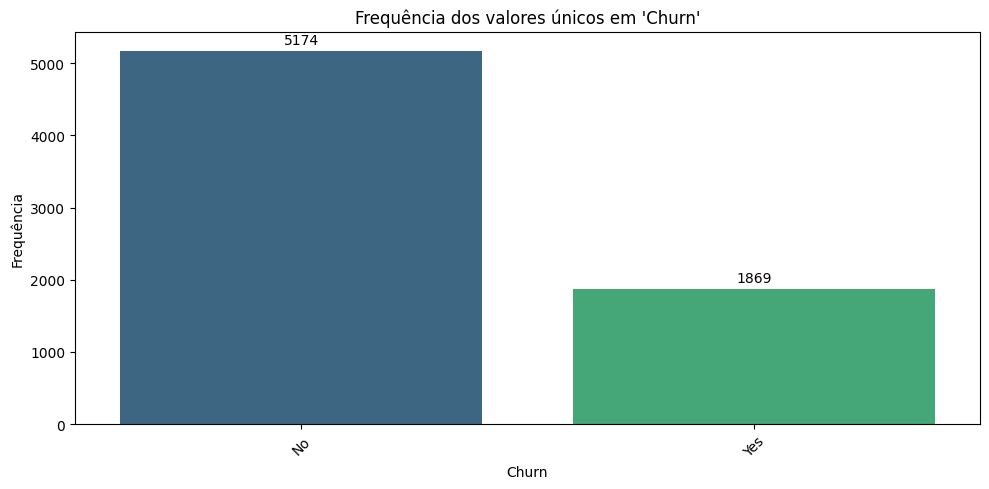

In [32]:
analisar_frequencia(data, 'Churn')

- A variável `Churn`, que representa o cancelamento de serviço, mostra que **aproximadamente 26,5% dos clientes cancelaram o serviço**. Trata-se de um índice expressivo que evidencia a importância de ações preventivas e estratégias de retenção. Do ponto de vista de modelagem, essa variável apresenta um certo **desbalanceamento de classes**, o que exige cuidados especiais na escolha de técnicas de modelagem e métricas de avaliação, para garantir que o modelo consiga identificar corretamente os clientes em risco, mesmo sendo uma minoria.

## **🔄 3. Bivariate Analysis (análise entre duas variáveis)**

### **3.1. Variáveis categóricas vs Churn**
Ver como o Churn varia com Contract, InternetService, etc.

In [33]:
def plot_categorical_churn_with_counts(df, categorical_vars, target='Churn', positive_class='Yes', ncols=2, figsize_per_plot=(8,5)):
    nplots = len(categorical_vars)
    nrows = (nplots + ncols - 1) // ncols
    
    plt.figure(figsize=(figsize_per_plot[0]*ncols, figsize_per_plot[1]*nrows))
    
    for i, cat_var in enumerate(categorical_vars, 1):
        plt.subplot(nrows, ncols, i)
        
        # Agrupar para contar total e calcular taxa de churn
        grouped = df.groupby(cat_var)
        counts = grouped.size()
        churn_rate = grouped[target].apply(lambda x: (x == positive_class).mean())
        
        # Criar dataframe para plotar
        plot_df = pd.DataFrame({'count': counts, 'churn_rate': churn_rate})
        plot_df = plot_df.sort_values('churn_rate', ascending=False).reset_index()
        
        # Plot barras para contagem
        ax1 = plt.gca()
        sns.barplot(x=cat_var, y='count', data=plot_df, color='lightgray', ax=ax1)
        ax1.set_ylabel('Número de Clientes', color='gray')
        ax1.set_xlabel(cat_var)
        ax1.tick_params(axis='x', rotation=45)
        
        # Adicionar números em cima das barras
        for idx, row in plot_df.iterrows():
            ax1.text(idx, row['count'] + max(plot_df['count'])*0.01, f"{row['count']}", 
                     ha='center', va='bottom', color='black', fontsize=9)
        
        # Criar eixo secundário para taxa de churn
        ax2 = ax1.twinx()
        sns.pointplot(x=cat_var, y='churn_rate', data=plot_df, color='red', ax=ax2)
        ax2.set_ylabel('Taxa de Churn (%)', color='red')
        ax2.set_ylim(0, 1)
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
        
        # Adicionar números ao lado dos pontos da linha
        for idx, row in plot_df.iterrows():
            ax2.text(idx, row['churn_rate'] + 0.03, f"{row['churn_rate']*100:.1f}%", 
                     ha='center', va='bottom', color='red', fontsize=9)
        
        plt.title(f'{cat_var} - Número de Clientes e Taxa de Churn')
    
    plt.tight_layout()
    plt.show()


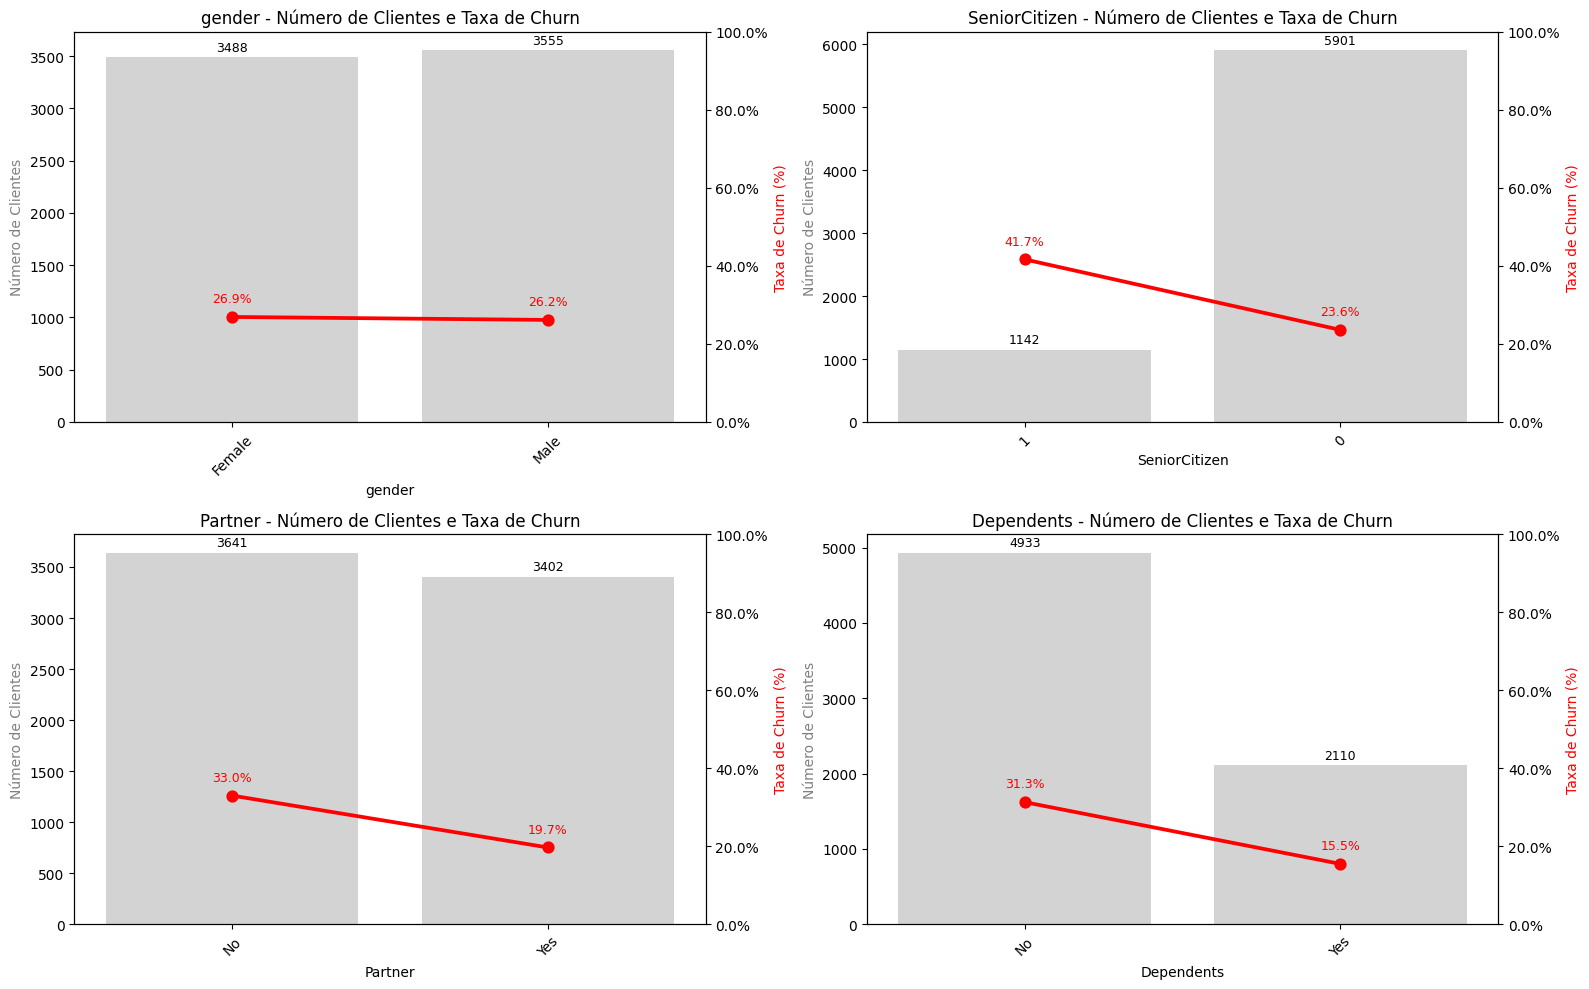

In [34]:
categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plot_categorical_churn_with_counts(data, categorical_vars)


**Gender:**
- Não há diferença significativa na taxa de churn entre gêneros. Portanto, gender não aparenta ser um bom preditor de churn.

**SeniorCitizen**
- Clientes idosos têm **quase o dobro de probabilidade de cancelar o serviço**. `SeniorCitizen` aparenta uma forte correlação com churn e deve ser considerada em qualquer modelo.

**Partner**
- Ter um parceiro está **associado com menor churn**. Possivelmente, clientes com parceiros têm mais estabilidade ou vínculos com o serviço.

**Dependents**
- Clientes com dependentes têm **menos propensão a cancelar** o serviço, talvez por dependerem mais da estabilidade. Essa variável também pode ser importante para o modelo
    

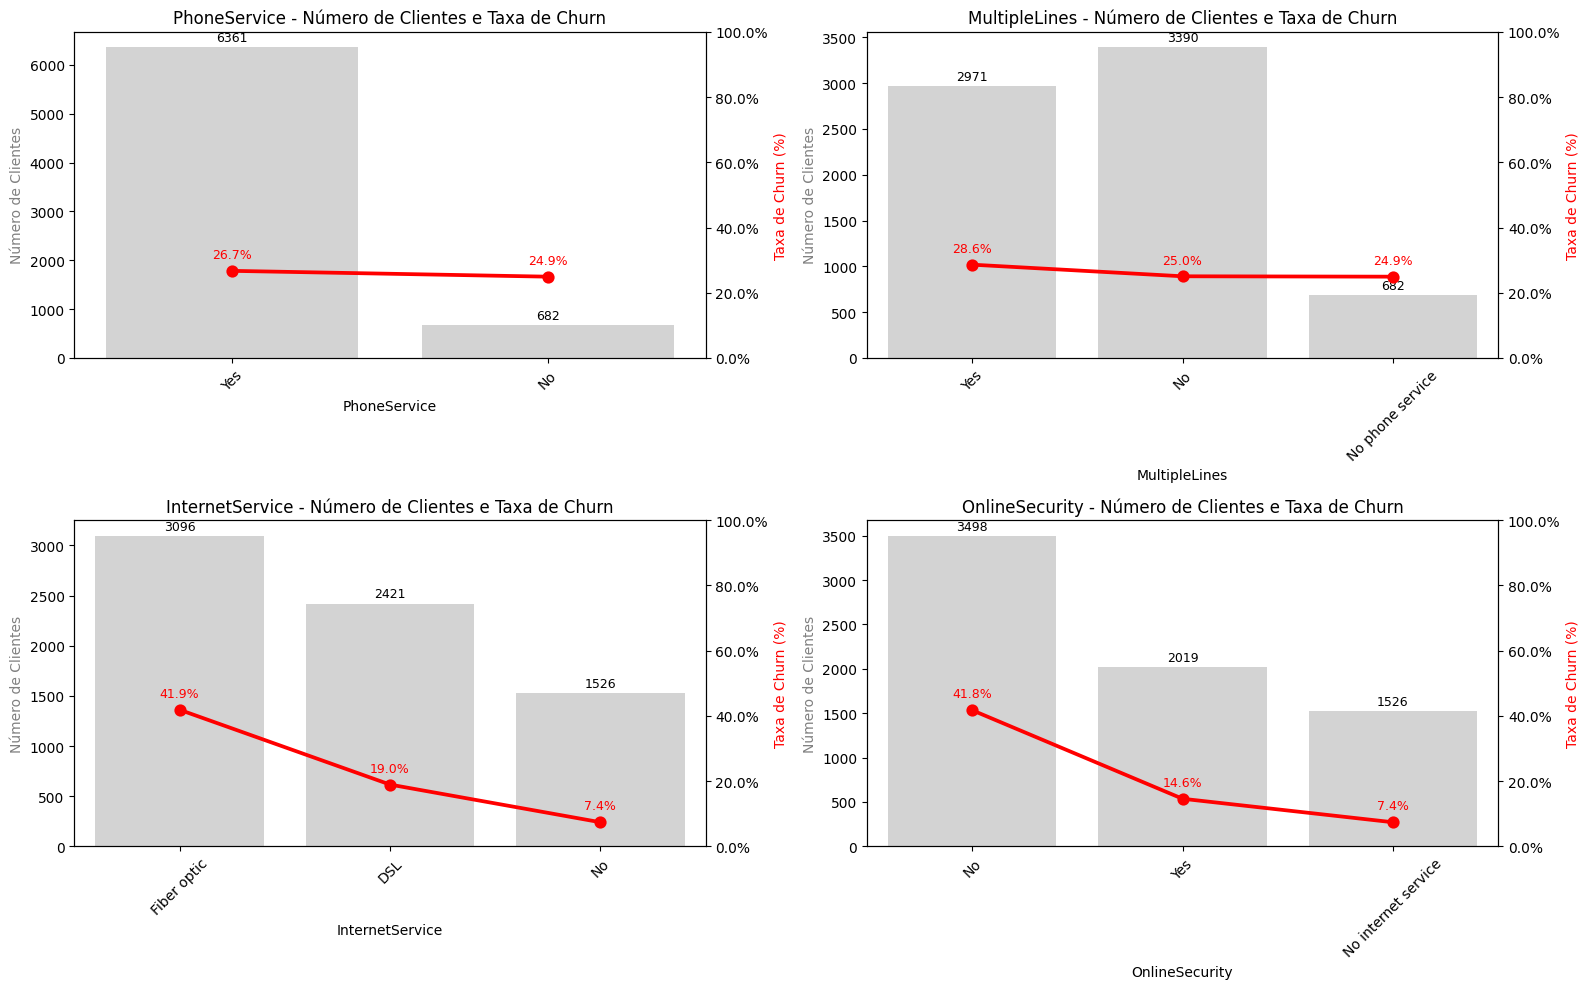

In [35]:
categorical_vars = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity']
plot_categorical_churn_with_counts(data, categorical_vars)

**PhoneService**

- A taxa de churn é **levemente maior** para quem possui serviço telefônico. Contudo, a diferença é pequena.

**MultipleLines**

- Ter múltiplas linhas está **levemente associado** a uma taxa maior de churn. Mas a diferença também não é tão expressiva.

**InternetService**

- Clientes com **fibra óptica têm altíssima taxa de churn**, muito superior aos que usam DSL. Quem **não tem internet dificilmente cancela**, o que pode ser por já não estarem engajados no serviço

**OnlineSecurity**

- Clientes **sem segurança online** têm uma taxa de churn muito maior. Isso mostra que **não contratar serviços adicionais de segurança** pode estar ligado à insatisfação.

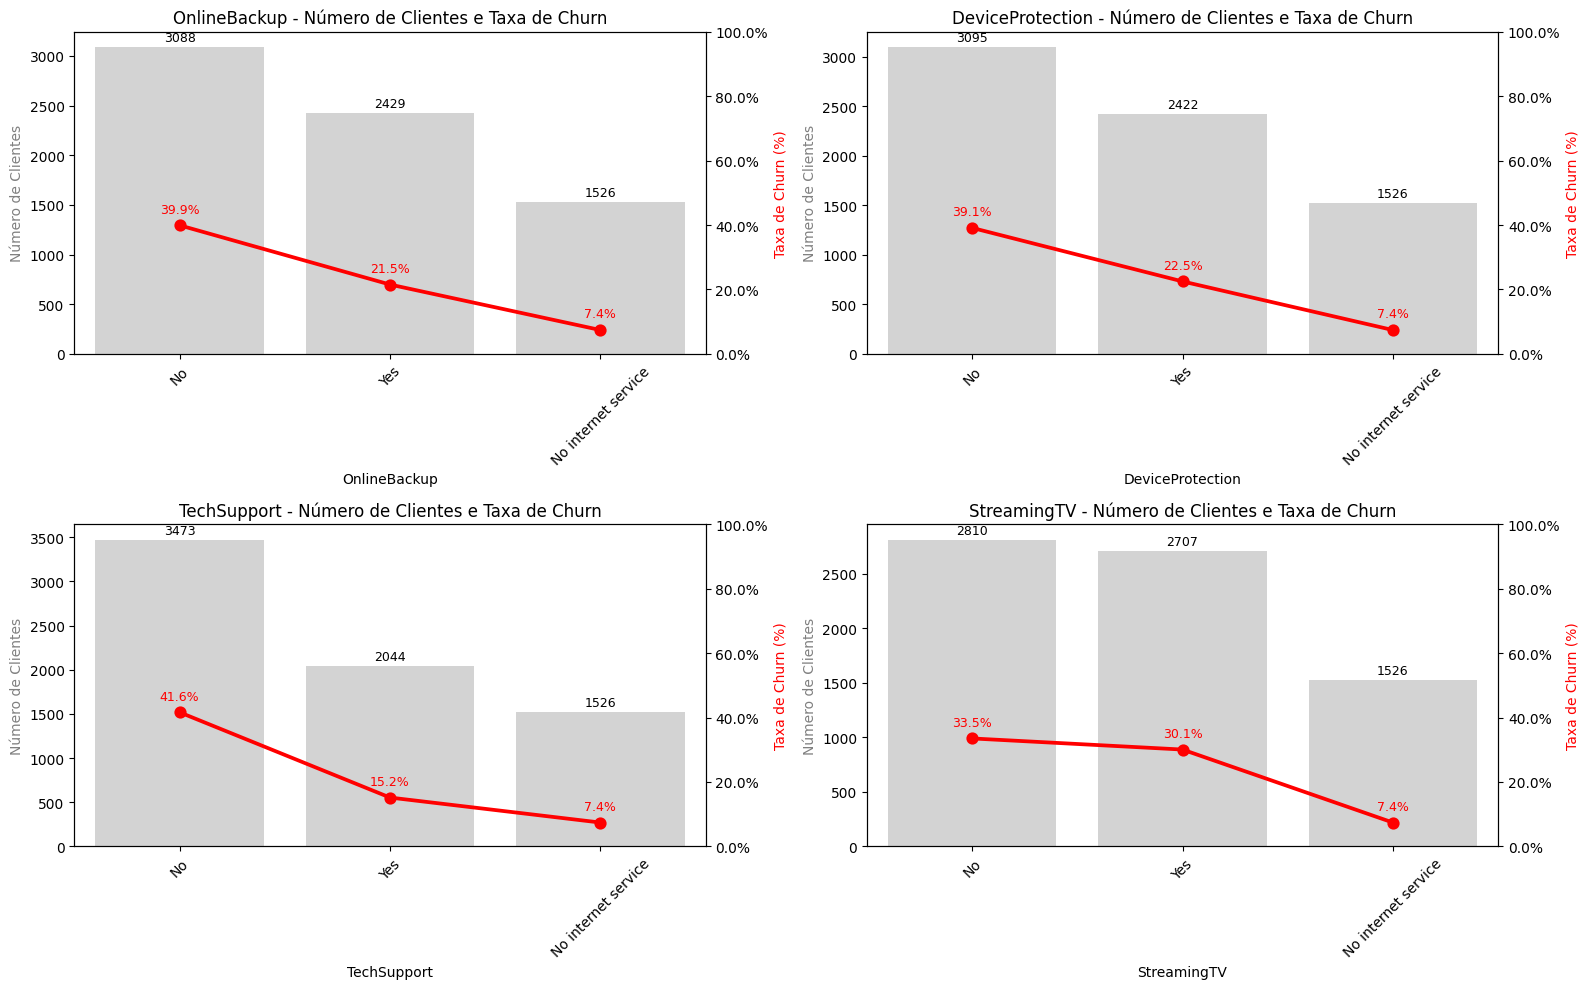

In [36]:
categorical_vars = ['OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV']
plot_categorical_churn_with_counts(data, categorical_vars)

**OnlineBackup**
- Clientes que **não têm backup online** apresentam **quase o dobro** da taxa de churn comparado aos que possuem.

**DeviceProtection**
- Mais uma vez, a **ausência de serviços adicionais** como proteção de dispositivos está relacionada a maior churn.

**TechSupport**
- Este é um dos maiores contrastes entre sim e não. Quem tem suporte técnico permanece muito mais. **Impacto muito alto** → TechSupport é um fortíssimo preditor de churn.
Estratégias que aumentem o uso ou a percepção de valor do suporte podem reduzir o churn drasticamente.

**StreamingTV**
- A diferença entre sim e não é **pequena**, mas existe. O churn é **ligeiramente maior para quem não usa StreamingTV**.

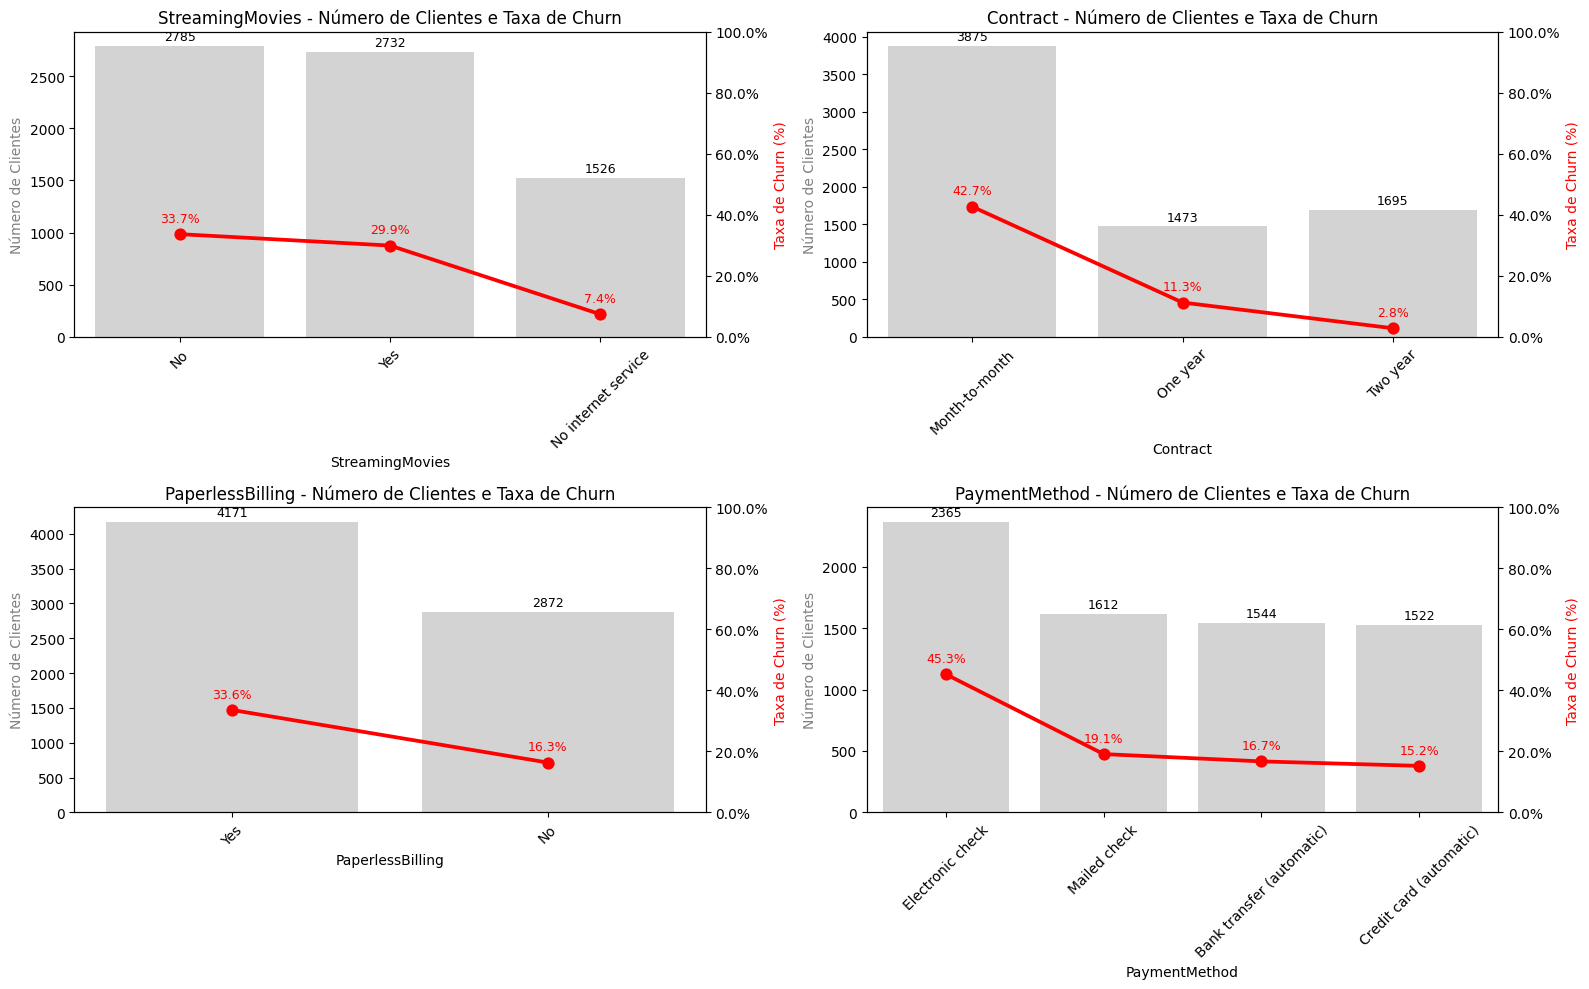

In [37]:
categorical_vars = ['StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
plot_categorical_churn_with_counts(data, categorical_vars)

**StreamingMovies**
- A diferença entre clientes que usam e não usam StreamingMovies é pequena (cerca de 4%).

**Contract**
- Clientes com contratos mais longos **churnam muito menos**.

**PaperlessBilling**
- Usuários com `PaperlessBilling` têm **o dobro da taxa de churn**. Pode indicar perfil mais digital, que troca de serviço com mais facilidade.

**PaymentMethod**
- Pagamentos automáticos (cartão e transferência) têm menor churn. `Electronic` check apresenta a **maior taxa de churn**.

### **3.2. Variáveis numéricas vs Churn**

In [38]:
def plot_numeric_vs_target(data, feature, target='Churn', figsize=(12, 6)):
    """
    Gera boxplot e violin plot para uma variável numérica específica vs variável target.
    
    Parâmetros:
        - data: DataFrame Pandas
        - feature: Nome da variável numérica a ser analisada
        - target: Nome da variável alvo (default = 'Churn')
        - figsize: Tamanho dos gráficos (default = (12, 6))
    """
    # Validação
    if feature not in data.columns:
        raise ValueError(f"A coluna '{feature}' não existe no DataFrame.")
    
    if not pd.api.types.is_numeric_dtype(data[feature]):
        raise TypeError(f"A coluna '{feature}' não é numérica.")

    plt.figure(figsize=figsize)

    # Boxplot com hue=target para evitar FutureWarning
    plt.subplot(1, 2, 1)
    sns.boxplot(x=target, y=feature, data=data, hue=target, palette="Set2", legend=False)
    plt.title(f'Boxplot: {feature} vs {target}')

    # Violin plot com hue=target para evitar FutureWarning
    plt.subplot(1, 2, 2)
    sns.violinplot(x=target, y=feature, data=data, hue=target, palette="Set2", legend=False)
    plt.title(f'Violin Plot: {feature} vs {target}')
    
    plt.tight_layout()
    plt.show()


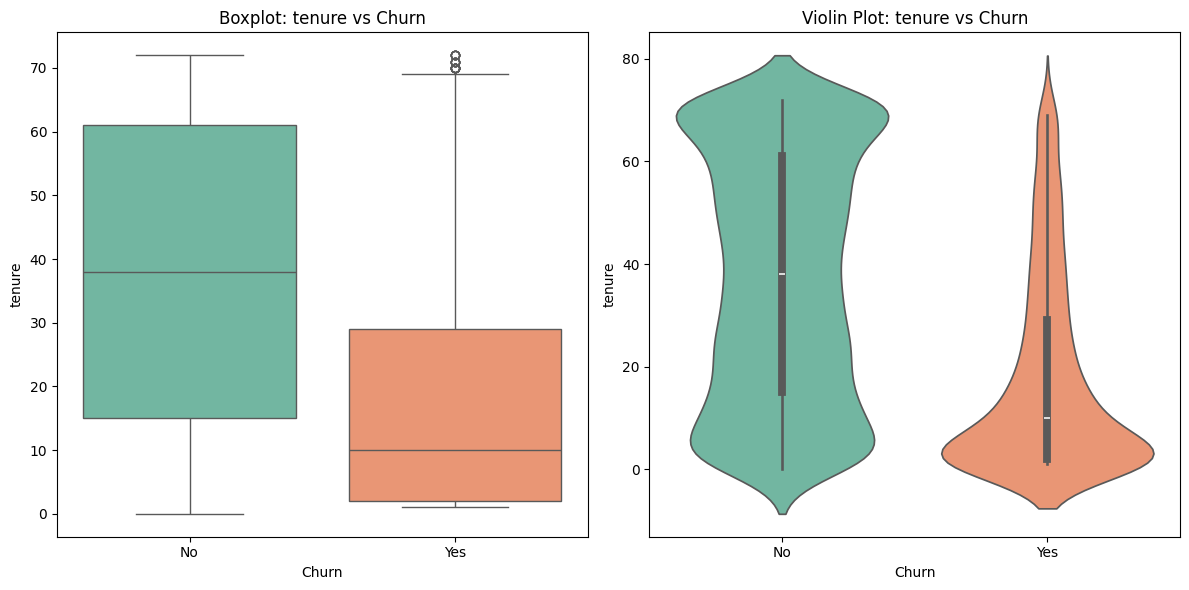

In [39]:
plot_numeric_vs_target(data, 'tenure')

**1. Clientes que NÃO saíram (`Churn = No`):**
- Têm uma distribuição de tenure muito mais ampla.

- A mediana está alta (por volta de 38 meses).

- Há muitos clientes com tempo de permanência entre 20 e 70 meses.

- Poucos outliers.

**2. Clientes que saíram (`Churn = Yes`):**
- A maioria tem tenure baixo (mediana por volta de 10 meses).

- A distribuição é concentrada nos primeiros meses de uso.

- A cauda direita mostra que alguns ficaram bastante tempo, mas são minoria.

- Há vários outliers para valores maiores de tenure.

**Conclusão**

- Clientes com **maior tempo de permanência** têm menor chance de cancelamento.

- O churn ocorre principalmente nos primeiros meses de relacionamento.

- Isso sugere que trabalhar em estratégias de retenção precoce **podem ser eficazes** para reduzir o churn.

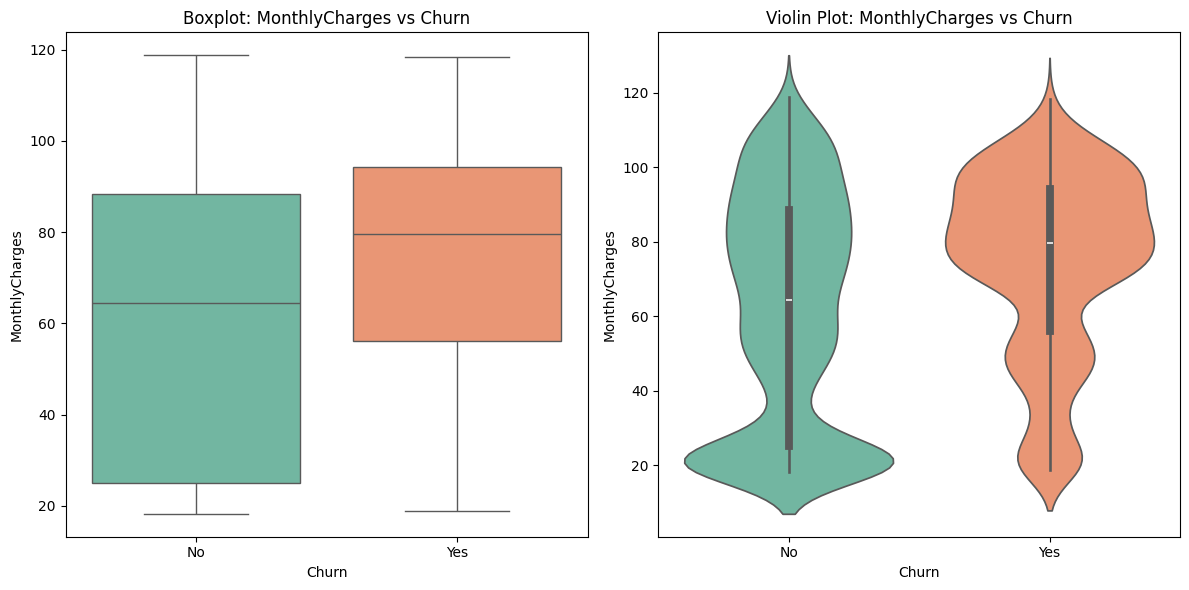

In [40]:
plot_numeric_vs_target(data, 'MonthlyCharges')

**1. Clientes que NÃO saíram (`Churn = No`):**

- Gastos mensais apresentam maior variabilidade, com muitos clientes pagando valores baixos a médios.

- A mediana está abaixo de 70.

- Distribuição mais espalhada e com alta densidade em valores baixos (como visto na parte larga inferior do violin plot).

**2. Clientes que saíram (`Churn = Yes`):**

- Os clientes que cancelaram têm uma mediana de gastos mais alta (próxima de 80).

- A densidade se concentra em valores mais altos de cobrança mensal (violin plot mais largo entre 70–100).

- Sugere que clientes com faturas mais caras tendem a cancelar com mais frequência.

**Conclusão**

- Clientes que pagam mais mensalmente têm maior propensão ao churn.

- Possivelmente, planos mais caros não estão atendendo às expectativas, ou causam insatisfação.

- Estratégias como melhor alinhamento de valor percebido com o custo ou ofertas para planos caros podem ajudar na retenção.

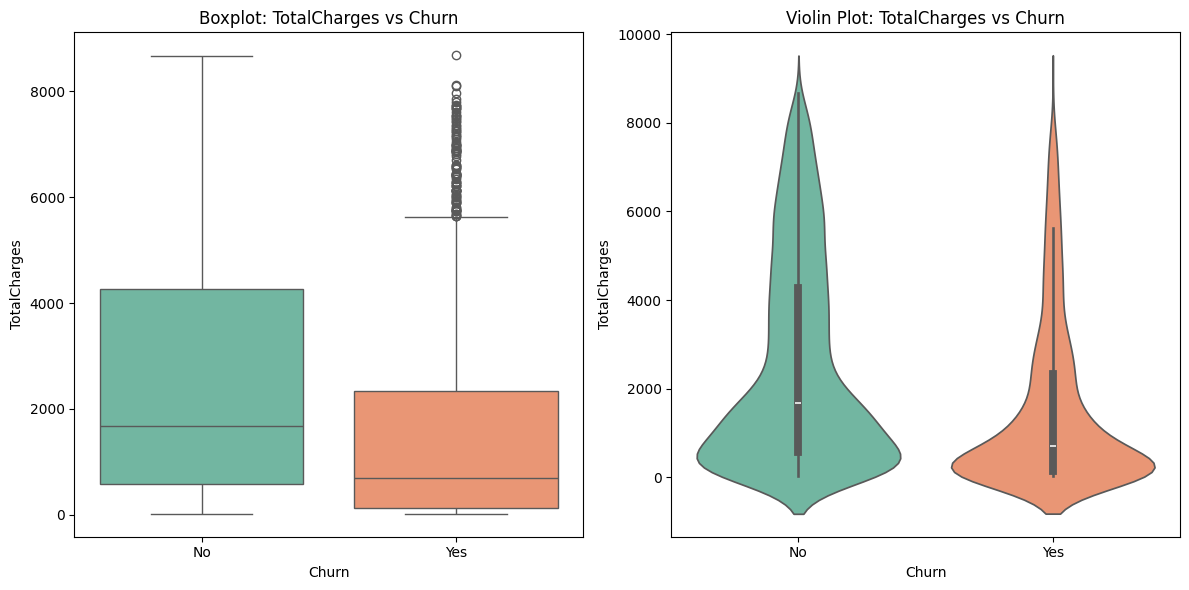

In [41]:
plot_numeric_vs_target(data, 'TotalCharges')

**1. Clientes que NÃO saíram (`Churn = No`):**

- `TotalCharges` desses clientes tende a ser mais alto comparado aos que saíram.

- A mediana dos gastos totais é significativamente maior.

- O boxplot mostra uma dispersão ampla, com vários outliers acima da mediana (clientes que gastaram muito ao longo do tempo).

- O violin plot reforça a densidade concentrada em níveis mais altos de `TotalCharges`, indicando que muitos desses clientes têm longa permanência e valores acumulados.

- Clientes fiéis tendem a acumular mais cobranças ao longo do tempo, pois continuam no serviço.

**2. Clientes que saíram (`Churn = Yes`):**

- A mediana de `TotalCharges` é bem mais baixa, mostrando que muitos cancelam nos primeiros meses.

- A distribuição é assimétrica, com concentração de densidade em valores baixos (violin plot com base larga entre 0–1000).

- O boxplot indica menos variabilidade nos valores e menos outliers extremos.

- Isso sugere que clientes que saem tendem a fazê-lo cedo — talvez por insatisfação inicial ou barreiras na adesão

**Conclusões (Insights):**

- Clientes com maiores `TotalCharges` tendem a permanecer — sinalizando maior tempo de permanência e possível satisfação com o serviço.

- Clientes que cancelam têm baixo `TotalCharges`, sugerindo problemas na experiência inicial.

- Estratégias para reduzir churn precoce são fundamentais:

- Melhor onboarding

- Suporte proativo nos primeiros meses

- Período de testes ou benefícios iniciai

## **🔗 4. Multivariate Analysis**

### **4.1. Correlação entre variáveis numéricas**

In [42]:
def analisar_correlacao(df, metodo=None, annot=True, figsize_heatmap=(10, 8), cmap='coolwarm'):
    """
    Analisa correlação entre variáveis numéricas e gera scatter plots.

    Parâmetros:
    - df: DataFrame do pandas.
    - metodo: Método de correlação ('pearson', 'spearman', 'kendall').
    - annot: Mostrar valores no heatmap.
    - figsize_heatmap: Tamanho da figura do heatmap.
    - figsize_scatters: Tamanho base da figura dos scatter plots.
    - cmap: Mapa de cores para o heatmap.

    Retorna:
    - Matriz de correlação.
    """
    # Seleciona colunas numéricas válidas (sem NaN)
    df_num = df.select_dtypes(include=['int64', 'float64']).dropna()

    if df_num.shape[1] < 2:
        print("É necessário ao menos duas variáveis numéricas.")
        return None

    # === 1. Matriz de Correlação ===
    corr_matrix = df_num.corr(method=metodo)

    plt.figure(figsize=figsize_heatmap)
    sns.heatmap(corr_matrix, annot=annot, cmap=cmap, fmt=".2f", square=True, linewidths=0.5)
    plt.title(f'Matriz de Correlação - Método: {metodo.capitalize()}', fontsize=14)
    plt.tight_layout()
    plt.show()

    return corr_matrix


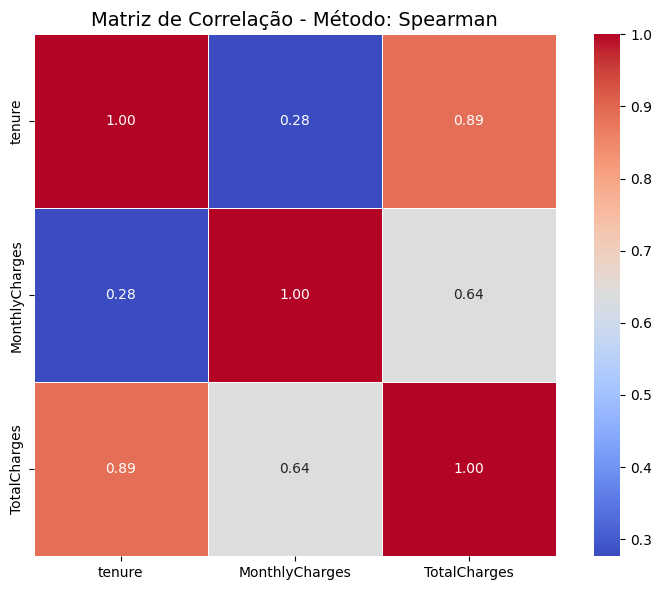

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.276417,0.886998
MonthlyCharges,0.276417,1.000000,0.637475
TotalCharges,0.886998,0.637475,1.000000


In [43]:
analisar_correlacao(data, metodo='spearman', figsize_heatmap=(8,6))


**🔹 Correlação entre tenure e TotalCharges (~0.89)**

- Isso era esperado, pois: `TotalCharges` é uma variável acumulativa — quanto maior o tempo de permanência (`tenure`), maior a cobrança total.

**🔹 Correlação entre MonthlyCharges e TotalCharges (~0.64)**

- Também é esperado, porque: `TotalCharges` ≈ `MonthlyCharges` × `tenure`, ou seja, mesmo que `MonthlyCharges` varie, ele ainda é um dos principais componentes de `TotalCharges`.

**🔹 Correlação entre tenure e MonthlyCharges (~0.28)**

- Essa relação é fraca, o que também faz sentido: O tempo que o cliente está no plano (`tenure`) não está diretamente ligado ao quanto ele paga por mês. Os planos podem ter valores mensais variados, independentemente do tempo de permanência.

### **4.2. Gráficos de pares**

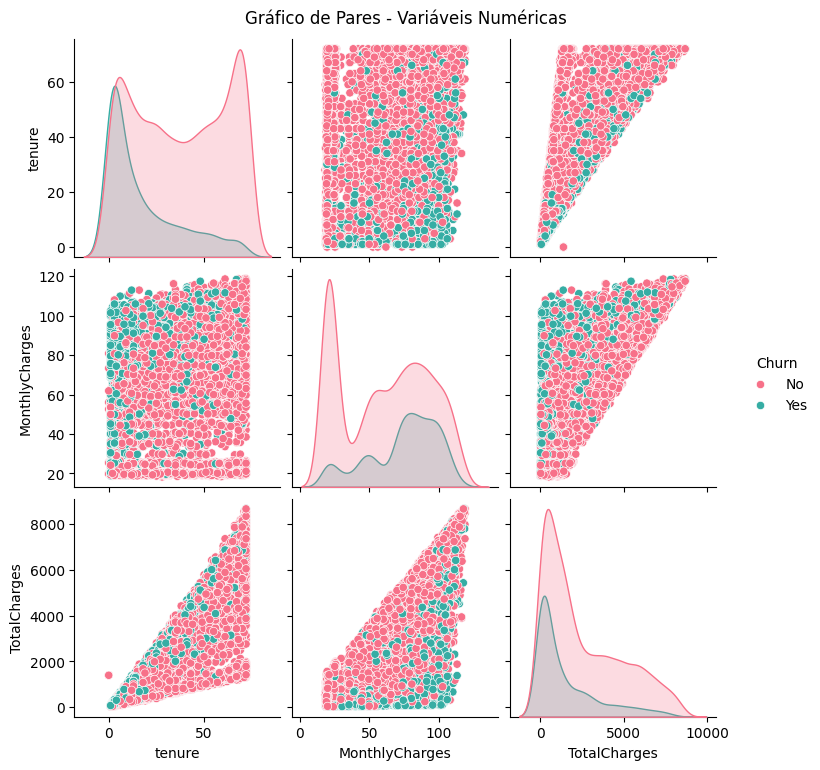

In [44]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Se seu DataFrame se chama df:
sns.pairplot(data[num_features + ['Churn']], hue='Churn', palette='husl', diag_kind='kde')
plt.suptitle('Gráfico de Pares - Variáveis Numéricas', y=1.02)
plt.show()

## **🧹 5. Preparação para Modelagem**

### **5.3. Balanceamento da variável alvo**

Verifique distribuição da variável Churn

### **5.1. Entendendo o Impacto das Variáveis Categóricas via Codificação e Correlação**

Antes de treinar o modelo de Machine Learning, é fundamental transformar as variáveis categóricas para um formato numérico que os algoritmos consigam interpretar corretamente. Como nosso objetivo inicial é identificar as variáveis mais relevantes para prever o Churn, adotamos uma estratégia de codificação mista com dois propósitos:

1. Verificar correlações lineares entre variáveis categóricas e a variável-alvo utilizando OneHotEncoder.

2. Posteriormente, aplicar LabelEncoder em todas as variáveis categóricas para alimentar um modelo de árvore (Random Forest), que é mais sensível a relações não lineares e permite avaliar a importância de cada feature na predição.

In [45]:
# Criando uma cópia do dataset original para o pré-processamento para o treinamento do modelo. 
data_model = data.copy()

In [46]:
# Removendo a coluna de CustomerID:
data_model = data_model.drop(columns=['customerID', 'gender'])

In [47]:
data_model['AvgMonthlySpend'] = data_model['TotalCharges'] / (data_model['tenure'] + 1)

# Quantos serviços online o cliente não possui
data_model['NoOnlineServices'] = (
    (data_model['OnlineSecurity'] == 'No').astype(int) +
    (data_model['OnlineBackup'] == 'No').astype(int) +
    (data_model['DeviceProtection'] == 'No').astype(int) +
    (data_model['TechSupport'] == 'No').astype(int)
)

# Quantos serviços de entretenimento não possui
data_model['NoStreaming'] = (
    (data_model['StreamingTV'] == 'No').astype(int) +
    (data_model['StreamingMovies'] == 'No').astype(int)
)

# Total de serviços que o cliente possui
def count_services(row):
    count = 0
    service_cols = [
        'PhoneService', 'MultipleLines', 'InternetService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    for col in service_cols:
        if 'No internet service' in row[col] or 'No phone service' in row[col]:
            continue
        if row[col] in ['Yes', 'Fiber optic', 'DSL']:
            count += 1
    return count

data_model['TotalServices'] = data_model.apply(count_services, axis=1)


# Risco de churn (heurística de score)
data_model['RiskScore'] = ((data_model['Contract'] == 'Month-to-month').astype(int) + (data_model['OnlineSecurity'] == 'No').astype(int) +
    (data_model['TechSupport'] == 'No').astype(int) + (data_model['PaymentMethod'] == 'Electronic check').astype(int) + (data_model['tenure'] < 6).astype(int))


Inicialmente aplicamos um método híbrido de transformação de variáveis, utilizando:

- **LabelEncoder** para variáveis binárias (ex: `Partner`, `Churn`, `PhoneService`), onde a codificação ordinal não distorce o significado dos dados.

- **OneHotEncoder** para variáveis com múltiplas categorias (ex: `InternetService`, `Contract`, `PaymentMethod`), garantindo que os algoritmos não assumam relações ordinais inexistentes entre as categorias.

Essa abordagem permite explorar a matriz de correlação entre as variáveis codificadas e o `Churn`. No entanto, é importante destacar que a correlação de Pearson mede apenas relações lineares, o que pode limitar a interpretação em casos mais complexos.

In [48]:
def transform_dataframe_hibryd_method(df):
    """
    Aplica LabelEncoder e OneHotEncoder conforme as colunas especificadas.
    
    Retorna um DataFrame com as colunas transformadas.
    """
    # Colunas para LabelEncoder
    label_cols = [ 'SeniorCitizen', 'Partner', 'Dependents','PhoneService', 'PaperlessBilling', 'Churn']
    
    # Colunas para OneHotEncoder
    onehot_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaymentMethod']
    
    df_transformed = df.copy()
    
    # Aplicando LabelEncoder
    label_encoder = LabelEncoder()
    for col in label_cols:
        df_transformed[col] = label_encoder.fit_transform(df_transformed[col])
    
    # Aplicando OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, drop=None)
    ohe_array = ohe.fit_transform(df_transformed[onehot_cols])
    ohe_columns = ohe.get_feature_names_out(onehot_cols)
    df_ohe = pd.DataFrame(ohe_array, columns=ohe_columns, index=df.index)
    
    # Remover colunas one-hot originais e adicionar as codificadas
    df_transformed.drop(columns=onehot_cols, inplace=True)
    df_final = pd.concat([df_transformed, df_ohe], axis=1)
    
    return df_final


In [49]:
df_encoded = transform_dataframe_hibryd_method(data_model)

#Verificando as dimensões: 
df_encoded.shape

(7043, 45)

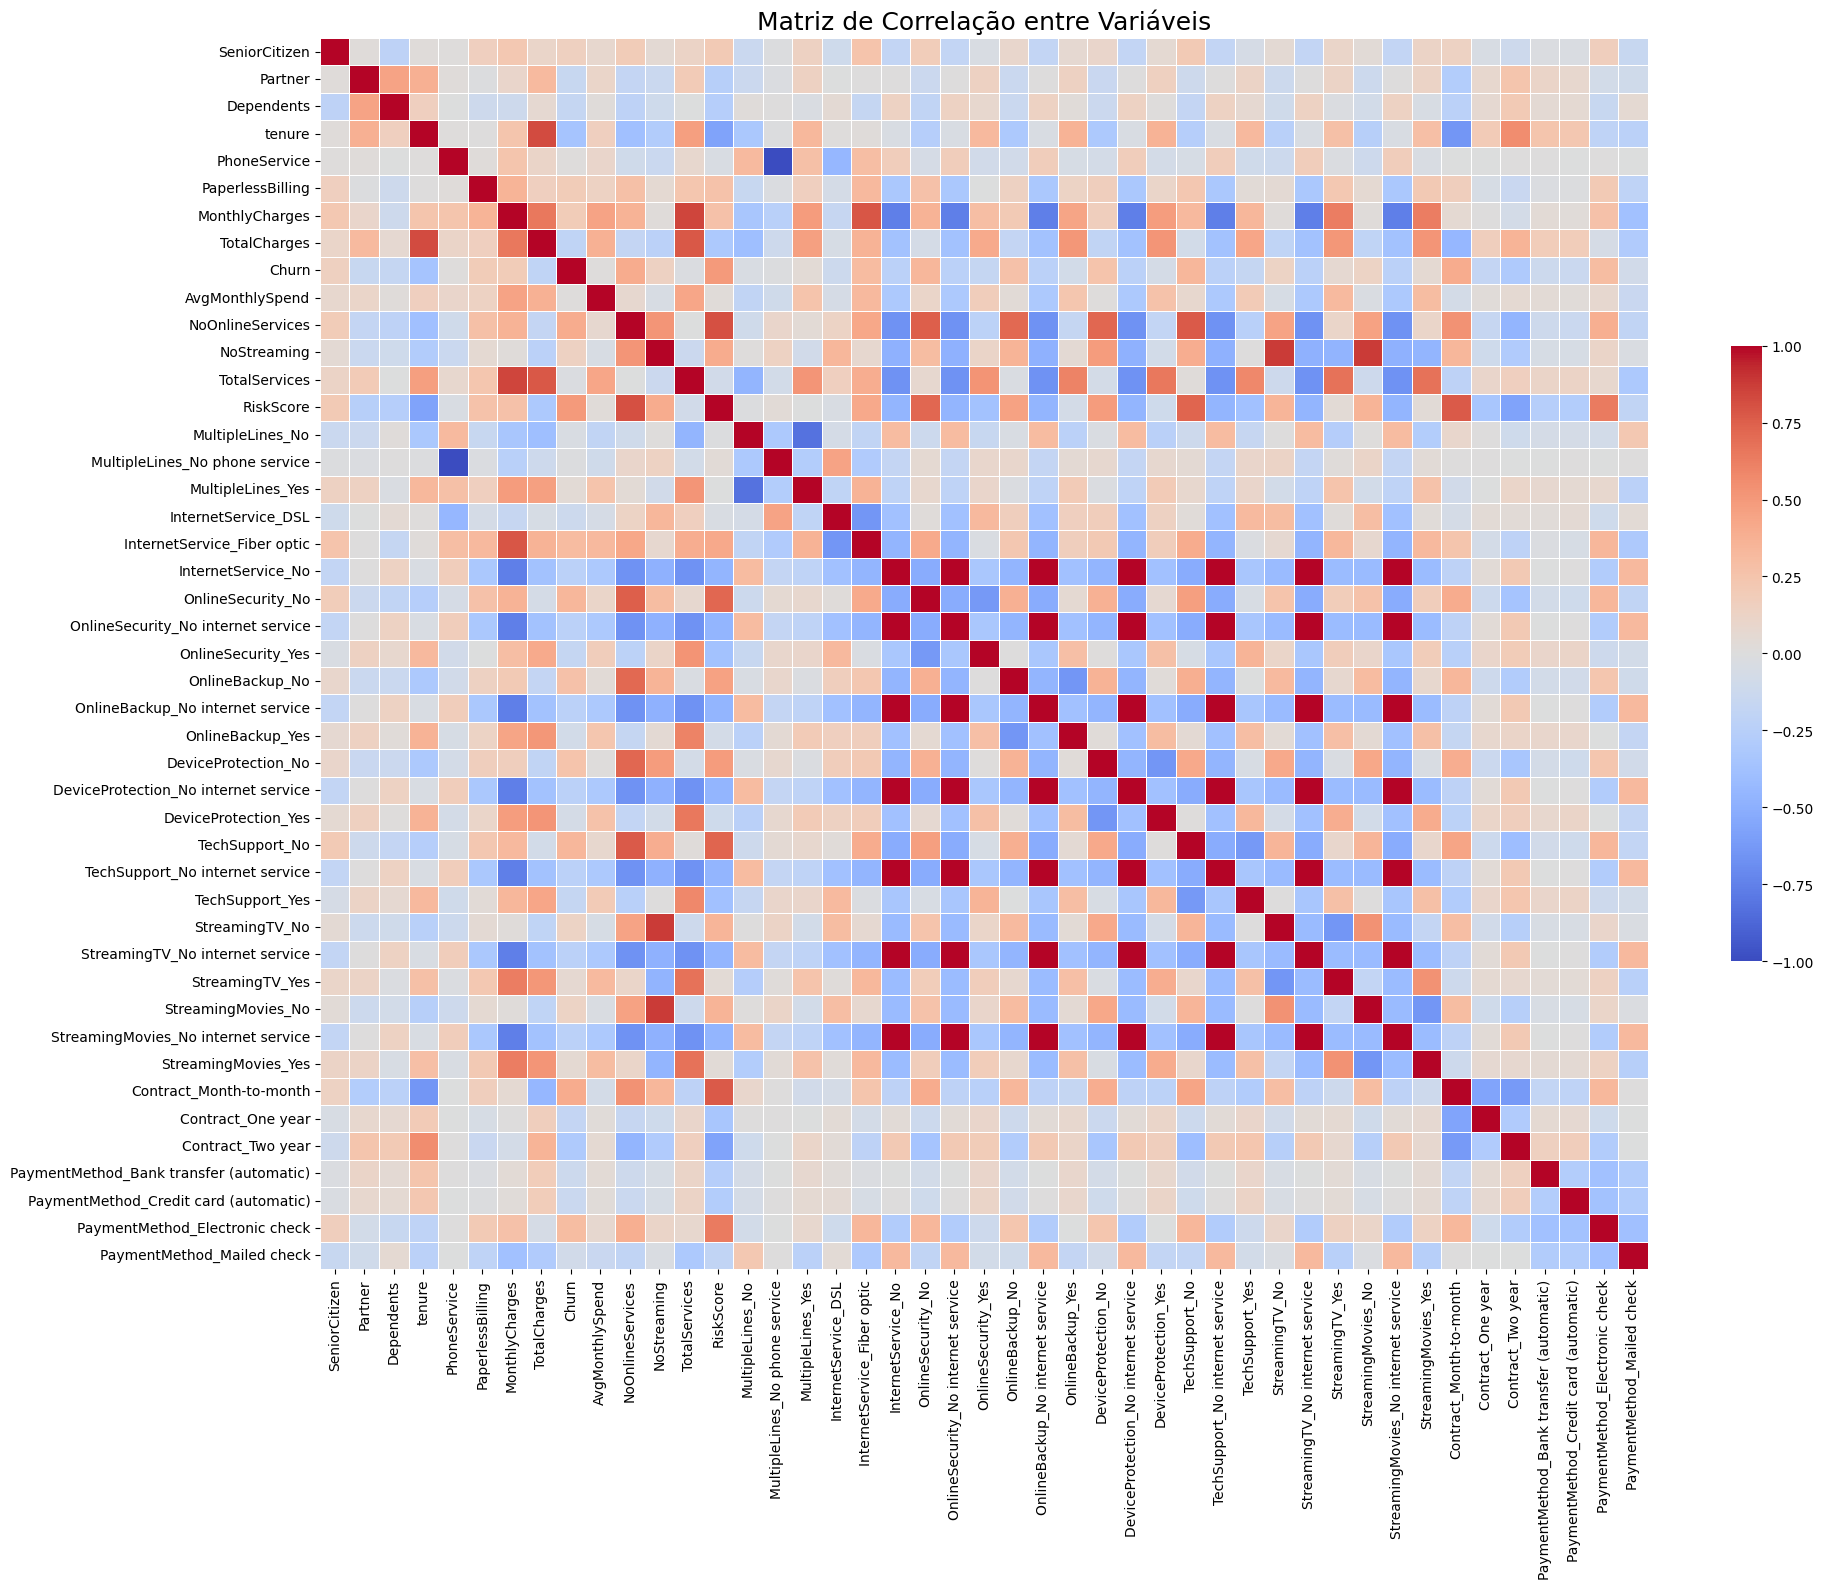

In [50]:
# Calcula a matriz de correlação
corr_matrix = df_encoded.corr()

# Define o tamanho da figura
plt.figure(figsize=(20, 16))

# Plota o heatmap
sns.heatmap(corr_matrix, 
            annot=False,  # se quiser exibir os valores, mude para True
            cmap='coolwarm', 
            center=0,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

# Título
plt.title('Matriz de Correlação entre Variáveis', fontsize=18)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [51]:
# Calcula a correlação de todas as variáveis com a variável alvo 'Churn'
churn_corr = df_encoded.corr()['Churn'].drop('Churn').sort_values(ascending=False)

# Exibe a lista
print(churn_corr)

RiskScore                                  0.499789
NoOnlineServices                           0.405400
Contract_Month-to-month                    0.405103
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
MonthlyCharges                             0.193356
PaperlessBilling                           0.191825
SeniorCitizen                              0.150889
NoStreaming                                0.148119
StreamingMovies_No                         0.130845
StreamingTV_No                             0.128916
StreamingTV_Yes                            0.063228
StreamingMovies_Yes                        0.061382
MultipleLines_Yes                          0.040102
AvgMonthlySpend                            0.014873
PhoneService

**Limitações da Análise Linear**

- Ao aplicar o OneHotEncoder e analisar a correlação entre as variáveis e o churn, observamos que:

- Poucas variáveis apresentaram correlação forte com a variável alvo.

- Isso pode indicar que existem relações não lineares mais complexas que não são capturadas pela simples análise de correlação.

Por isso, decidimos complementar a análise com um modelo baseado em árvores, que consegue capturar interações e relações não lineares entre as variáveis.

Modelos baseados em árvores, como o Random Forest, não são sensíveis à escala ou ordens artificiais criadas por LabelEncoder, e conseguem tratar adequadamente variáveis categóricas mesmo quando codificadas como inteiros. Assim, transformamos todas as variáveis categóricas com o LabelEncoder, o que:

- Evita a alta dimensionalidade causada por OneHotEncoder, especialmente quando temos muitas variáveis com múltiplas categorias.

- Permite uma análise direta da importância das features através dos critérios de divisão do modelo (Gini ou Entropia).

- Captura relações não lineares entre as variáveis e o Churn.

In [52]:
def apply_label_encoding(df):
    """
    Aplica LabelEncoder em todas as colunas categóricas (tipo 'object') do DataFrame.
    
    Parâmetros:
    df (pd.DataFrame): DataFrame de entrada
    
    Retorna:
    pd.DataFrame: DataFrame com colunas categóricas codificadas
    """
    df_encoded = df.copy()
    label_encoders = {}
    
    for col in df_encoded.select_dtypes(include='object').columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le  # Guarda o encoder, caso queira reverter depois

    return df_encoded, label_encoders

In [53]:
df_encoded, encoders = apply_label_encoding(data_model)
df_encoded.head()


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AvgMonthlySpend,NoOnlineServices,NoStreaming,TotalServices,RiskScore
0,0,1,0,1,0,1,0,0,2,0,...,1,2,29.85,29.85,0,14.925000,3,2,2,5
1,0,0,0,34,1,0,0,2,0,2,...,0,3,56.95,1889.50,0,53.985714,2,2,4,1
2,0,0,0,2,1,0,0,2,2,0,...,1,3,53.85,108.15,1,36.050000,2,2,4,3
3,0,0,0,45,0,1,0,2,0,2,...,0,0,42.30,1840.75,0,40.016304,1,2,4,0
4,0,0,0,2,1,0,1,0,0,0,...,1,2,70.70,151.65,1,50.550000,4,2,2,5


              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1294
           1       0.65      0.47      0.54       467

    accuracy                           0.79      1761
   macro avg       0.74      0.69      0.70      1761
weighted avg       0.78      0.79      0.78      1761



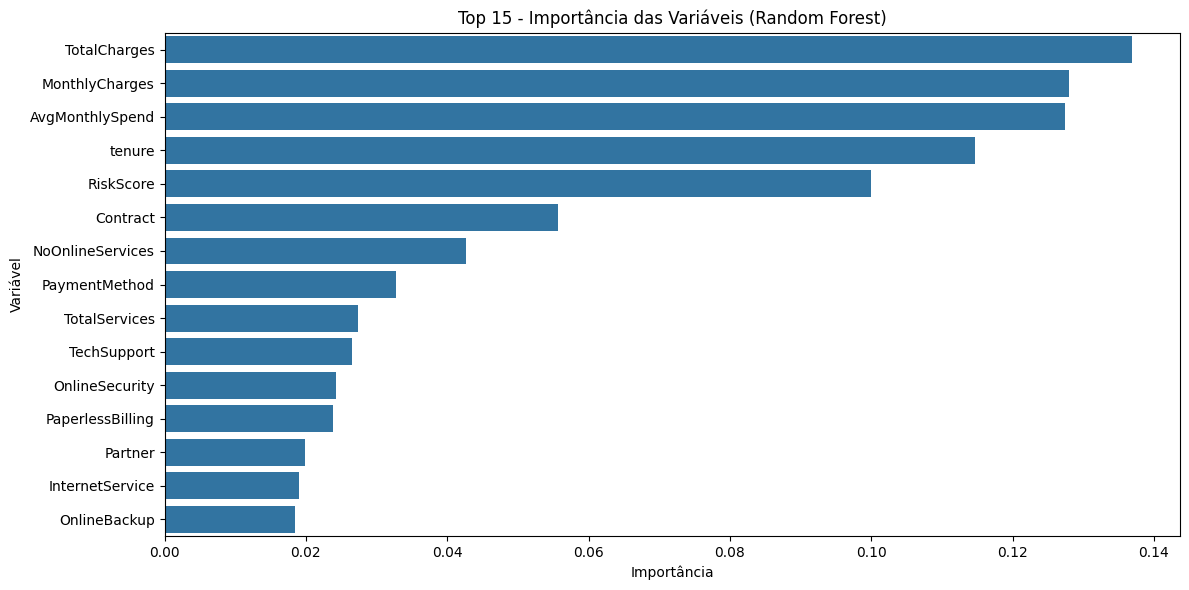

In [54]:
# 1. Preparar os dados
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# 2. Treinar modelo RandomForest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 3. Avaliar modelo
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# 4. Importância das features (Random Forest)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title("Top 15 - Importância das Variáveis (Random Forest)")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()


### **5.2. Pré-Processamento**

In [58]:
# 1. Aplicar label encoding com sua função
df_encoded, label_encoders = apply_label_encoding(data_model)

# 2. Separar features e target
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 3. Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Aplicar SMOTE após a divisão do treino
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 5. Inicializar RandomForest com class_weight balanceado
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 6. Definir parâmetros para GridSearch
param_grid = {
    'n_estimators': [100, 200, 400, 600],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
    }

# 7. GridSearchCV com validação cruzada
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# 8. Iniciar experimento MLflow e rodar o treino
with mlflow.start_run(run_name="RandomForest_SMOTE_GridSearch_4_scoring_f1", nested=True) as run:
    grid_search.fit(X_resampled, y_resampled)
    
    # 9. Previsões no conjunto de teste original
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 10. Avaliação das métricas
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # 11. Logar parâmetros do melhor modelo
    mlflow.log_params(grid_search.best_params_)
    
    # 12. Logar métricas
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    
    # 13. Logar o modelo treinado
    mlflow.sklearn.log_model(best_model, "random_forest_model")
    
    # 14. Impressão dos resultados
    print("Melhores parâmetros encontrados:", grid_search.best_params_)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


2025/06/03 20:06:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhores parâmetros encontrados: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.56      0.69      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.79      0.77      0.78      1409

Confusion Matrix:
 [[829 206]
 [115 259]]


In [56]:
# 1. Aplicar label encoding com sua função
df_encoded, label_encoders = apply_label_encoding(data_model)

# 2. Separar features e target
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 3. Dividir em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Aplicar SMOTE após a divisão do treino
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 5. Inicializar XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 6. Definir parâmetros para GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 7. GridSearchCV com validação cruzada
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)

# 8. Iniciar experimento MLflow e rodar o treino
with mlflow.start_run(run_name="XGBoost_SMOTE_GridSearch_f1", nested=True) as run:
    grid_search.fit(X_resampled, y_resampled)

    # 9. Previsões no conjunto de teste original
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 10. Avaliação das métricas
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # 11. Logar parâmetros do melhor modelo
    mlflow.log_params(grid_search.best_params_)

    # 12. Logar métricas
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)

    # 13. Logar o modelo treinado
    mlflow.sklearn.log_model(best_model, "xgboost_model")

    # 14. Impressão dos resultados
    print("Melhores parâmetros encontrados:", grid_search.best_params_)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


d:\MLOPS\MLOPS_PROJECT_TELCO_CUSTUMER_CHURCH\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:06:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
2025/06/03 14:06:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Melhores parâmetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1035
           1       0.57      0.64      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.79      0.78      0.78      1409

Confusion Matrix:
 [[853 182]
 [133 241]]
